In [14]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder,StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge,Lasso, ElasticNet
from sklearn.ensemble import ExtraTreesRegressor, VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error,r2_score, make_scorer, mean_absolute_error
from sklearn.ensemble import (
    AdaBoostRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
import lightgbm as lgb
import matplotlib.pyplot as plt

In [15]:
df = pd.read_csv(r"data/20_preprocessed.csv")

#### The data set contains information about the last 79210 claim payments made.

- total_claim_amount - Amount of the claim payment in dollars
- severity - The severity rating of damage to the patient, from 1 (emotional trauma) to 9 (death)
- age - Age of the claimant in years
- private_attorney - Whether the claimant was represented by a private attorney
- marital_status - Marital status of the claimant
- specialty - Specialty of the physician involved in the lawsuit
- insurance - Type of medical insurance carried by the patient
- gender - Patient Gender

### Data Types
- #### total_claim_amount
   - Numeric Column
- #### severity
   - Rating of damage from 1 (emotional trauma) to 9 (death)
- #### age 
   - Numeric Column
- #### private_attorney
   - Represented by a private attorney or not => 0 (Not Private), 1 (Private)
- #### marital_status
   - 0 (Divorced), 1 (Single), 2 (Married), 3 (Widowed), 4 (Unknown)
- #### specialty
   - Specialty of the physician (Categorical column with 20 different categories
- #### insurance
   - Type of medical insurance Private, Unknown,Medicare/Medicaid,No Insurance,Workers Compensation
- #### gender
   - Gender of the insured (Male or Female)

In [16]:
df.drop(labels="Unnamed: 0", axis=1,inplace = True)

In [17]:
df.head()

,total_claim_amount,severity,age,private_attorney,marital_status,specialty,insurance,gender
0,57041,7,62,1,2,Family Practice,Private,Male
1,324976,6,38,1,2,OBGYN,No Insurance,Female
2,135383,4,34,1,2,Cardiology,Unknown,Male
3,829742,7,42,1,1,Pediatrics,No Insurance,Female
4,197675,3,60,0,2,OBGYN,Medicare/Medicaid,Female


In [25]:
def cat_conversion(df):
    for i in df.select_dtypes(include = 'object').columns:
        df[i] = df[i].apply(lambda x:x.lower())
    return df

cat_transformer = FunctionTransformer(cat_conversion)

def age_preprocessing(df):
    import numpy as np
    # age
    mean_age = df['age'].median()
    df['age'] = df['age'].fillna(mean_age)

    df['age'] = np.where((df['age']>=0) & (df['age']<2), 'infant(0-2)',
                                        np.where((df['age']>=2) & (df['age']<12),'kid(2-12)',
                                        np.where((df['age']>=12) & (df['age']<18),'teen(12-18)',
                                        np.where((df['age']>=18) & (df['age']<35),'young adult(18-35)',
                                        np.where((df['age']>=35) & (df['age']<60),'adult(35-60)',
                                        np.where(df['age']>=60,'senior(60+)','error'))))))
    

    return df

age_preprocessing_transformer = FunctionTransformer(age_preprocessing)

#### Splitting into X and y

In [26]:
X = df.drop(labels = 'total_claim_amount',axis = 1)
y = df['total_claim_amount']

In [27]:
X.shape,y.shape

((79210, 7), (79210,))

#### Splitting into train and test datasets

In [28]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=42)

#### Creating a pipeline and a preprocessor object

In [29]:
numerical_columns = ['severity','private_attorney','marital_status']
categorical_columns = ['specialty','insurance','gender']
age_columns = ['age']

numerical_pipeline = Pipeline(steps = 
                              [('scaler',StandardScaler(with_mean=False))]
                             )
categorical_pipeline = Pipeline(steps=[('cat_conversion', cat_transformer),
                                       ('one_hot_encoder',OneHotEncoder())
                                      ]
                               )

age_pipeline = Pipeline(steps=[('age_preprocessor',age_preprocessing_transformer),
                               ('one_hot_encoder',OneHotEncoder())
                              ]
                               )

preprocessor = ColumnTransformer([
    ('age_pipeline',age_pipeline,age_columns),
    ('num_pipeline',numerical_pipeline,numerical_columns),
    ('categorical_pipeline',categorical_pipeline,categorical_columns)
])

X_train_transformed = preprocessor.fit_transform(X_train).toarray()

X_train_transformed.shape

X_test_transformed = preprocessor.transform(X_test).toarray()

In [30]:
import dill

# Load the saved scaler
with open('./artifacts/preprocessor.pkl', 'wb') as f:
    scaler_loaded = dill.dump(preprocessor, f)

In [33]:
list[df['specialty'].unique()]

list[array(['Family Practice', 'OBGYN', 'Cardiology', 'Pediatrics',
       'Internal Medicine', 'Anesthesiology', 'Emergency Medicine',
       'Ophthamology', 'Urological Surgery', 'Orthopedic Surgery',
       'Neurology/Neurosurgery', 'Occupational Medicine', 'Resident',
       'Thoracic Surgery', 'General Surgery', 'Radiology', 'Pathology',
       'Physical Medicine', 'Plastic Surgeon', 'Dermatology'],
      dtype=object)]

In [24]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Elastic Net Regression': ElasticNet(),
    'Decision Tree Regression': DecisionTreeRegressor(),
    'Random Forest Regression': RandomForestRegressor(),
    'Gradient Boosting Regression': GradientBoostingRegressor(),
    'XGBoost Regression': XGBRegressor(),
    "LightGBM": lgb.LGBMRegressor(),
    'CatBoost Regression': CatBoostRegressor(),
    'Extra Trees Regression': ExtraTreesRegressor()
}


In [11]:
def adjusted_r2_score(y_true, y_pred, n, p):
    r2 = r2_score(y_true, y_pred)
    return 1 - ((1 - r2) * (n - 1)) / (n - p - 1)

### Cross-Validation results

In [20]:
# Defining a function to evaluate the models 
def evaluate_models(x_train,y_train,x_test,y_test,models):
    try:
        trained_models ={}
        r2_train_list = []
        mae_train_list = []
        mse_train_list = []
        
        
        mse = make_scorer(mean_squared_error)
        mae = make_scorer(mean_absolute_error)

        for i in range(len(list(models))):
            
            # Cross Validation
            model =  list(models.values())[i]
            
            r2_scores = cross_val_score(model, x_train, y_train, cv=3, scoring= 'r2')
            mae_scores = cross_val_score(model, x_train, y_train, cv=3, scoring= mae)
            mse_scores = cross_val_score(model, x_train, y_train, cv=3, scoring= mse)

            
            r2_train_list.append(np.mean(r2_scores))
            mae_train_list.append(np.mean(mae_scores))
            mse_train_list.append(np.mean(mse_scores))
                

        return r2_train_list,mae_train_list,mse_train_list
    except Exception as e:
        print(e)

In [21]:
r2_list,mae_list,mse_list = evaluate_models(x_train=X_train_transformed,y_train=y_train,x_test = X_test_transformed,y_test= y_test,models=models)

C:\Users\kpoli\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.951e+13, tolerance: 1.374e+11
  model = cd_fast.enet_coordinate_descent(
C:\Users\kpoli\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.954e+13, tolerance: 1.372e+11
  model = cd_fast.enet_coordinate_descent(
C:\Users\kpoli\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.943e+13, toleranc

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 83
[LightGBM] [Info] Number of data points in the train set: 36964, number of used features: 36
[LightGBM] [Info] Start training from score 156825.834920
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 83
[LightGBM] [Info] Number of data points in the train set: 36965, number of used features: 36
[LightGBM] [Info] Start training from score 157236.458623
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

96:	learn: 123945.1888638	total: 960ms	remaining: 8.94s
97:	learn: 123846.3875522	total: 979ms	remaining: 9.01s
98:	learn: 123729.3396821	total: 1s	remaining: 9.13s
99:	learn: 123599.6546667	total: 1.01s	remaining: 9.11s
100:	learn: 123485.5121135	total: 1.02s	remaining: 9.07s
101:	learn: 123431.4895383	total: 1.03s	remaining: 9.04s
102:	learn: 123322.8636087	total: 1.03s	remaining: 9.01s
103:	learn: 123231.8016862	total: 1.04s	remaining: 9.01s
104:	learn: 123199.1269548	total: 1.05s	remaining: 9s
105:	learn: 123148.4300691	total: 1.06s	remaining: 8.97s
106:	learn: 123040.2103892	total: 1.07s	remaining: 8.98s
107:	learn: 122938.8061468	total: 1.09s	remaining: 8.98s
108:	learn: 122811.3080012	total: 1.1s	remaining: 8.96s
109:	learn: 122690.2940102	total: 1.11s	remaining: 8.96s
110:	learn: 122626.4140242	total: 1.12s	remaining: 8.95s
111:	learn: 122518.9970999	total: 1.13s	remaining: 8.94s
112:	learn: 122476.2319531	total: 1.14s	remaining: 8.91s
113:	learn: 122385.8235323	total: 1.15s	re

251:	learn: 117130.8673014	total: 2.16s	remaining: 6.41s
252:	learn: 117116.8733074	total: 2.17s	remaining: 6.39s
253:	learn: 117104.2463070	total: 2.17s	remaining: 6.38s
254:	learn: 117078.7512783	total: 2.18s	remaining: 6.37s
255:	learn: 117049.5512463	total: 2.19s	remaining: 6.35s
256:	learn: 117033.9616985	total: 2.19s	remaining: 6.34s
257:	learn: 117005.5430319	total: 2.2s	remaining: 6.33s
258:	learn: 116978.1502514	total: 2.21s	remaining: 6.31s
259:	learn: 116941.5902968	total: 2.21s	remaining: 6.3s
260:	learn: 116919.0323303	total: 2.22s	remaining: 6.29s
261:	learn: 116896.9189601	total: 2.23s	remaining: 6.28s
262:	learn: 116874.1899606	total: 2.24s	remaining: 6.28s
263:	learn: 116850.0480830	total: 2.25s	remaining: 6.28s
264:	learn: 116830.9501714	total: 2.26s	remaining: 6.28s
265:	learn: 116806.5811068	total: 2.27s	remaining: 6.27s
266:	learn: 116764.4426378	total: 2.28s	remaining: 6.26s
267:	learn: 116743.8874093	total: 2.29s	remaining: 6.25s
268:	learn: 116720.1911668	total:

399:	learn: 114740.7046830	total: 3.35s	remaining: 5.02s
400:	learn: 114724.2301203	total: 3.35s	remaining: 5.01s
401:	learn: 114712.1247400	total: 3.36s	remaining: 5s
402:	learn: 114701.6629798	total: 3.37s	remaining: 4.99s
403:	learn: 114690.8515578	total: 3.38s	remaining: 4.98s
404:	learn: 114678.2928351	total: 3.38s	remaining: 4.97s
405:	learn: 114666.2970064	total: 3.39s	remaining: 4.96s
406:	learn: 114652.9586998	total: 3.4s	remaining: 4.95s
407:	learn: 114642.3697226	total: 3.41s	remaining: 4.94s
408:	learn: 114637.5154652	total: 3.41s	remaining: 4.93s
409:	learn: 114612.9366334	total: 3.42s	remaining: 4.92s
410:	learn: 114605.3739625	total: 3.43s	remaining: 4.91s
411:	learn: 114597.5613057	total: 3.44s	remaining: 4.9s
412:	learn: 114584.8475168	total: 3.44s	remaining: 4.89s
413:	learn: 114573.7106790	total: 3.45s	remaining: 4.89s
414:	learn: 114566.3129754	total: 3.46s	remaining: 4.88s
415:	learn: 114557.5677069	total: 3.47s	remaining: 4.87s
416:	learn: 114549.0926743	total: 3.

552:	learn: 113294.4118688	total: 4.54s	remaining: 3.67s
553:	learn: 113285.1229364	total: 4.55s	remaining: 3.67s
554:	learn: 113277.8863998	total: 4.56s	remaining: 3.66s
555:	learn: 113274.4461076	total: 4.57s	remaining: 3.65s
556:	learn: 113264.4663970	total: 4.58s	remaining: 3.64s
557:	learn: 113258.4336355	total: 4.58s	remaining: 3.63s
558:	learn: 113250.2049870	total: 4.59s	remaining: 3.62s
559:	learn: 113243.7917468	total: 4.6s	remaining: 3.62s
560:	learn: 113241.5138960	total: 4.62s	remaining: 3.61s
561:	learn: 113228.6852419	total: 4.62s	remaining: 3.6s
562:	learn: 113219.8862968	total: 4.63s	remaining: 3.6s
563:	learn: 113215.7019844	total: 4.64s	remaining: 3.59s
564:	learn: 113207.3273968	total: 4.65s	remaining: 3.58s
565:	learn: 113198.4101808	total: 4.66s	remaining: 3.57s
566:	learn: 113188.9219464	total: 4.66s	remaining: 3.56s
567:	learn: 113179.6817092	total: 4.67s	remaining: 3.55s
568:	learn: 113171.0324223	total: 4.68s	remaining: 3.54s
569:	learn: 113152.3613789	total: 

702:	learn: 112172.9709363	total: 5.75s	remaining: 2.43s
703:	learn: 112171.2622557	total: 5.76s	remaining: 2.42s
704:	learn: 112168.9876072	total: 5.76s	remaining: 2.41s
705:	learn: 112164.7526082	total: 5.77s	remaining: 2.4s
706:	learn: 112161.5104904	total: 5.78s	remaining: 2.4s
707:	learn: 112155.6550530	total: 5.79s	remaining: 2.39s
708:	learn: 112149.6276457	total: 5.8s	remaining: 2.38s
709:	learn: 112141.7383760	total: 5.81s	remaining: 2.37s
710:	learn: 112137.2074781	total: 5.81s	remaining: 2.36s
711:	learn: 112130.3324305	total: 5.82s	remaining: 2.35s
712:	learn: 112125.8422120	total: 5.83s	remaining: 2.35s
713:	learn: 112119.8983791	total: 5.84s	remaining: 2.34s
714:	learn: 112111.3633088	total: 5.85s	remaining: 2.33s
715:	learn: 112104.9225765	total: 5.86s	remaining: 2.32s
716:	learn: 112101.5307290	total: 5.86s	remaining: 2.31s
717:	learn: 112093.5959071	total: 5.87s	remaining: 2.31s
718:	learn: 112087.7839417	total: 5.88s	remaining: 2.3s
719:	learn: 112081.3619494	total: 5

851:	learn: 111431.8825031	total: 6.94s	remaining: 1.21s
852:	learn: 111427.4301920	total: 6.96s	remaining: 1.2s
853:	learn: 111425.2484045	total: 6.97s	remaining: 1.19s
854:	learn: 111419.5765286	total: 6.98s	remaining: 1.18s
855:	learn: 111414.2723136	total: 6.99s	remaining: 1.18s
856:	learn: 111410.5258541	total: 6.99s	remaining: 1.17s
857:	learn: 111405.3093088	total: 7s	remaining: 1.16s
858:	learn: 111398.7224338	total: 7.01s	remaining: 1.15s
859:	learn: 111396.7518517	total: 7.02s	remaining: 1.14s
860:	learn: 111393.7273994	total: 7.03s	remaining: 1.13s
861:	learn: 111388.8715083	total: 7.04s	remaining: 1.13s
862:	learn: 111386.2200355	total: 7.05s	remaining: 1.12s
863:	learn: 111383.4303293	total: 7.05s	remaining: 1.11s
864:	learn: 111375.8359345	total: 7.06s	remaining: 1.1s
865:	learn: 111374.0272572	total: 7.07s	remaining: 1.09s
866:	learn: 111371.4769644	total: 7.08s	remaining: 1.08s
867:	learn: 111369.6282372	total: 7.08s	remaining: 1.08s
868:	learn: 111364.8710309	total: 7.

Learning rate set to 0.072425
0:	learn: 186731.0694727	total: 9ms	remaining: 8.99s
1:	learn: 181491.1001574	total: 21.6ms	remaining: 10.8s
2:	learn: 176906.2433432	total: 30.5ms	remaining: 10.1s
3:	learn: 172645.3077965	total: 37.4ms	remaining: 9.31s
4:	learn: 168834.8107152	total: 43.1ms	remaining: 8.57s
5:	learn: 165483.0593457	total: 52.6ms	remaining: 8.71s
6:	learn: 162541.2775209	total: 66.9ms	remaining: 9.49s
7:	learn: 159642.1776298	total: 74ms	remaining: 9.17s
8:	learn: 157313.2756479	total: 80.6ms	remaining: 8.88s
9:	learn: 155031.6108512	total: 87ms	remaining: 8.61s
10:	learn: 152834.6024181	total: 92.6ms	remaining: 8.32s
11:	learn: 151025.1469905	total: 99.4ms	remaining: 8.18s
12:	learn: 149598.7864083	total: 106ms	remaining: 8.03s
13:	learn: 148056.5000594	total: 112ms	remaining: 7.87s
14:	learn: 146602.0885667	total: 119ms	remaining: 7.82s
15:	learn: 145306.7236619	total: 126ms	remaining: 7.75s
16:	learn: 144104.4147938	total: 132ms	remaining: 7.65s
17:	learn: 143190.15500

156:	learn: 119646.8111702	total: 1.18s	remaining: 6.33s
157:	learn: 119607.5190841	total: 1.19s	remaining: 6.32s
158:	learn: 119545.8145589	total: 1.19s	remaining: 6.31s
159:	learn: 119498.0409845	total: 1.2s	remaining: 6.29s
160:	learn: 119445.1116429	total: 1.21s	remaining: 6.29s
161:	learn: 119404.2323294	total: 1.21s	remaining: 6.27s
162:	learn: 119330.7244719	total: 1.22s	remaining: 6.26s
163:	learn: 119267.8812035	total: 1.23s	remaining: 6.25s
164:	learn: 119211.0869321	total: 1.23s	remaining: 6.23s
165:	learn: 119165.6917507	total: 1.24s	remaining: 6.22s
166:	learn: 119118.4147474	total: 1.24s	remaining: 6.21s
167:	learn: 119054.5832002	total: 1.25s	remaining: 6.2s
168:	learn: 118991.5294911	total: 1.26s	remaining: 6.18s
169:	learn: 118960.9362713	total: 1.26s	remaining: 6.17s
170:	learn: 118931.6884952	total: 1.27s	remaining: 6.16s
171:	learn: 118860.4588352	total: 1.28s	remaining: 6.15s
172:	learn: 118825.9332779	total: 1.28s	remaining: 6.14s
173:	learn: 118800.5527952	total:

303:	learn: 115524.7110536	total: 2.38s	remaining: 5.44s
304:	learn: 115490.0531575	total: 2.38s	remaining: 5.44s
305:	learn: 115477.8627719	total: 2.39s	remaining: 5.42s
306:	learn: 115467.1225004	total: 2.4s	remaining: 5.42s
307:	learn: 115447.6082016	total: 2.41s	remaining: 5.42s
308:	learn: 115433.2025270	total: 2.42s	remaining: 5.41s
309:	learn: 115425.0321626	total: 2.42s	remaining: 5.4s
310:	learn: 115408.2989482	total: 2.43s	remaining: 5.39s
311:	learn: 115382.0611974	total: 2.44s	remaining: 5.38s
312:	learn: 115356.3476933	total: 2.45s	remaining: 5.37s
313:	learn: 115342.1410007	total: 2.46s	remaining: 5.37s
314:	learn: 115324.8577850	total: 2.46s	remaining: 5.36s
315:	learn: 115293.4397770	total: 2.49s	remaining: 5.38s
316:	learn: 115279.9495556	total: 2.5s	remaining: 5.39s
317:	learn: 115267.2332301	total: 2.51s	remaining: 5.38s
318:	learn: 115256.5910933	total: 2.51s	remaining: 5.37s
319:	learn: 115229.4938946	total: 2.52s	remaining: 5.36s
320:	learn: 115217.2291635	total: 

455:	learn: 113402.4932180	total: 3.58s	remaining: 4.28s
456:	learn: 113392.6976153	total: 3.59s	remaining: 4.27s
457:	learn: 113384.1061858	total: 3.6s	remaining: 4.26s
458:	learn: 113378.5803457	total: 3.61s	remaining: 4.25s
459:	learn: 113369.3202640	total: 3.62s	remaining: 4.24s
460:	learn: 113358.7831632	total: 3.62s	remaining: 4.24s
461:	learn: 113348.2171229	total: 3.63s	remaining: 4.23s
462:	learn: 113341.2196705	total: 3.64s	remaining: 4.22s
463:	learn: 113333.6734192	total: 3.65s	remaining: 4.21s
464:	learn: 113325.9032571	total: 3.65s	remaining: 4.2s
465:	learn: 113316.4489503	total: 3.66s	remaining: 4.2s
466:	learn: 113308.0636367	total: 3.67s	remaining: 4.19s
467:	learn: 113295.6264758	total: 3.68s	remaining: 4.18s
468:	learn: 113285.4447009	total: 3.69s	remaining: 4.17s
469:	learn: 113276.2502040	total: 3.7s	remaining: 4.17s
470:	learn: 113265.8641884	total: 3.71s	remaining: 4.16s
471:	learn: 113260.0059468	total: 3.71s	remaining: 4.15s
472:	learn: 113253.6219681	total: 3

615:	learn: 112060.9645206	total: 5s	remaining: 3.12s
616:	learn: 112054.0242798	total: 5.01s	remaining: 3.11s
617:	learn: 112048.2109470	total: 5.02s	remaining: 3.1s
618:	learn: 112044.2052745	total: 5.02s	remaining: 3.09s
619:	learn: 112040.0138388	total: 5.03s	remaining: 3.08s
620:	learn: 112038.4615341	total: 5.04s	remaining: 3.07s
621:	learn: 112034.1447206	total: 5.04s	remaining: 3.06s
622:	learn: 112026.6922624	total: 5.05s	remaining: 3.06s
623:	learn: 112021.8791527	total: 5.06s	remaining: 3.05s
624:	learn: 112018.8225065	total: 5.06s	remaining: 3.04s
625:	learn: 112014.5547070	total: 5.07s	remaining: 3.03s
626:	learn: 112010.1953600	total: 5.08s	remaining: 3.02s
627:	learn: 112003.5349193	total: 5.09s	remaining: 3.01s
628:	learn: 111994.7687861	total: 5.09s	remaining: 3s
629:	learn: 111990.4655142	total: 5.1s	remaining: 3s
630:	learn: 111987.4164828	total: 5.11s	remaining: 2.99s
631:	learn: 111982.8944746	total: 5.11s	remaining: 2.98s
632:	learn: 111979.6340370	total: 5.12s	re

771:	learn: 111161.3832078	total: 6.2s	remaining: 1.83s
772:	learn: 111155.7921292	total: 6.21s	remaining: 1.82s
773:	learn: 111151.8573564	total: 6.22s	remaining: 1.82s
774:	learn: 111148.1737595	total: 6.23s	remaining: 1.81s
775:	learn: 111137.6115480	total: 6.24s	remaining: 1.8s
776:	learn: 111131.6173474	total: 6.24s	remaining: 1.79s
777:	learn: 111127.2584876	total: 6.25s	remaining: 1.78s
778:	learn: 111123.2790874	total: 6.26s	remaining: 1.78s
779:	learn: 111119.9195571	total: 6.27s	remaining: 1.77s
780:	learn: 111118.1336159	total: 6.28s	remaining: 1.76s
781:	learn: 111115.3011055	total: 6.29s	remaining: 1.75s
782:	learn: 111106.0753327	total: 6.29s	remaining: 1.74s
783:	learn: 111102.8233621	total: 6.3s	remaining: 1.74s
784:	learn: 111099.4754591	total: 6.31s	remaining: 1.73s
785:	learn: 111093.5084683	total: 6.32s	remaining: 1.72s
786:	learn: 111090.9148324	total: 6.32s	remaining: 1.71s
787:	learn: 111084.6672687	total: 6.33s	remaining: 1.7s
788:	learn: 111076.7214425	total: 6

923:	learn: 110524.1845047	total: 7.4s	remaining: 609ms
924:	learn: 110521.1910990	total: 7.41s	remaining: 601ms
925:	learn: 110518.2242124	total: 7.41s	remaining: 593ms
926:	learn: 110514.9071987	total: 7.42s	remaining: 585ms
927:	learn: 110509.7900460	total: 7.43s	remaining: 577ms
928:	learn: 110507.0059574	total: 7.44s	remaining: 569ms
929:	learn: 110503.5388379	total: 7.45s	remaining: 561ms
930:	learn: 110501.7435026	total: 7.45s	remaining: 552ms
931:	learn: 110493.6538573	total: 7.46s	remaining: 545ms
932:	learn: 110487.8204999	total: 7.47s	remaining: 537ms
933:	learn: 110483.8324556	total: 7.48s	remaining: 529ms
934:	learn: 110477.7465283	total: 7.49s	remaining: 521ms
935:	learn: 110474.1105997	total: 7.5s	remaining: 513ms
936:	learn: 110472.6653925	total: 7.51s	remaining: 505ms
937:	learn: 110469.7552386	total: 7.51s	remaining: 497ms
938:	learn: 110467.7431604	total: 7.52s	remaining: 488ms
939:	learn: 110464.2072972	total: 7.53s	remaining: 480ms
940:	learn: 110459.4468575	total:

73:	learn: 125246.6256052	total: 577ms	remaining: 7.22s
74:	learn: 125149.9881903	total: 587ms	remaining: 7.24s
75:	learn: 125016.1589301	total: 595ms	remaining: 7.23s
76:	learn: 124915.0776315	total: 602ms	remaining: 7.22s
77:	learn: 124852.5900899	total: 609ms	remaining: 7.2s
78:	learn: 124749.5563438	total: 619ms	remaining: 7.21s
79:	learn: 124624.8885810	total: 626ms	remaining: 7.2s
80:	learn: 124520.6350619	total: 634ms	remaining: 7.2s
81:	learn: 124384.9002178	total: 642ms	remaining: 7.18s
82:	learn: 124337.0023796	total: 648ms	remaining: 7.16s
83:	learn: 124239.2651120	total: 657ms	remaining: 7.16s
84:	learn: 124133.4517484	total: 664ms	remaining: 7.15s
85:	learn: 124036.6438220	total: 672ms	remaining: 7.14s
86:	learn: 123981.9885175	total: 679ms	remaining: 7.13s
87:	learn: 123943.2478649	total: 686ms	remaining: 7.11s
88:	learn: 123871.7728790	total: 695ms	remaining: 7.11s
89:	learn: 123827.5308734	total: 702ms	remaining: 7.1s
90:	learn: 123780.0306939	total: 710ms	remaining: 7.

241:	learn: 116684.6837995	total: 2s	remaining: 6.26s
242:	learn: 116665.8894742	total: 2.01s	remaining: 6.25s
243:	learn: 116641.9152074	total: 2.02s	remaining: 6.25s
244:	learn: 116624.1831035	total: 2.02s	remaining: 6.24s
245:	learn: 116587.2615660	total: 2.03s	remaining: 6.24s
246:	learn: 116567.9929392	total: 2.04s	remaining: 6.24s
247:	learn: 116544.2846729	total: 2.05s	remaining: 6.23s
248:	learn: 116523.2761450	total: 2.06s	remaining: 6.21s
249:	learn: 116506.2136537	total: 2.07s	remaining: 6.2s
250:	learn: 116492.2097684	total: 2.07s	remaining: 6.19s
251:	learn: 116465.1032127	total: 2.08s	remaining: 6.18s
252:	learn: 116443.2585440	total: 2.09s	remaining: 6.16s
253:	learn: 116406.7921962	total: 2.09s	remaining: 6.15s
254:	learn: 116395.9727648	total: 2.1s	remaining: 6.14s
255:	learn: 116370.8558625	total: 2.11s	remaining: 6.13s
256:	learn: 116338.2089588	total: 2.12s	remaining: 6.12s
257:	learn: 116288.9808460	total: 2.13s	remaining: 6.12s
258:	learn: 116275.4738489	total: 2.

396:	learn: 114182.3093203	total: 3.21s	remaining: 4.88s
397:	learn: 114172.3944688	total: 3.22s	remaining: 4.87s
398:	learn: 114159.5659751	total: 3.23s	remaining: 4.86s
399:	learn: 114150.8973943	total: 3.24s	remaining: 4.86s
400:	learn: 114129.1969236	total: 3.25s	remaining: 4.85s
401:	learn: 114116.7621221	total: 3.25s	remaining: 4.84s
402:	learn: 114107.5089597	total: 3.26s	remaining: 4.83s
403:	learn: 114095.8228562	total: 3.27s	remaining: 4.83s
404:	learn: 114086.8099957	total: 3.28s	remaining: 4.82s
405:	learn: 114074.5495773	total: 3.29s	remaining: 4.82s
406:	learn: 114056.8346321	total: 3.31s	remaining: 4.82s
407:	learn: 114041.9243003	total: 3.31s	remaining: 4.81s
408:	learn: 114028.0891793	total: 3.32s	remaining: 4.8s
409:	learn: 114018.0620806	total: 3.33s	remaining: 4.79s
410:	learn: 114009.5169769	total: 3.34s	remaining: 4.78s
411:	learn: 114003.2050838	total: 3.35s	remaining: 4.77s
412:	learn: 113994.8294428	total: 3.35s	remaining: 4.77s
413:	learn: 113988.1912929	total

547:	learn: 112859.6345344	total: 4.43s	remaining: 3.65s
548:	learn: 112855.1715241	total: 4.44s	remaining: 3.65s
549:	learn: 112851.2599347	total: 4.45s	remaining: 3.64s
550:	learn: 112841.3860006	total: 4.45s	remaining: 3.63s
551:	learn: 112833.9909313	total: 4.46s	remaining: 3.62s
552:	learn: 112825.5534002	total: 4.47s	remaining: 3.61s
553:	learn: 112821.9414872	total: 4.48s	remaining: 3.6s
554:	learn: 112804.9511064	total: 4.49s	remaining: 3.6s
555:	learn: 112790.9060966	total: 4.5s	remaining: 3.59s
556:	learn: 112783.7333920	total: 4.5s	remaining: 3.58s
557:	learn: 112771.2568080	total: 4.51s	remaining: 3.57s
558:	learn: 112756.9441891	total: 4.52s	remaining: 3.56s
559:	learn: 112752.7470562	total: 4.52s	remaining: 3.55s
560:	learn: 112749.3458810	total: 4.53s	remaining: 3.54s
561:	learn: 112744.0830589	total: 4.54s	remaining: 3.54s
562:	learn: 112737.7217471	total: 4.56s	remaining: 3.54s
563:	learn: 112724.1810341	total: 4.57s	remaining: 3.53s
564:	learn: 112719.4604390	total: 4

693:	learn: 111913.3909374	total: 5.65s	remaining: 2.49s
694:	learn: 111909.3617696	total: 5.66s	remaining: 2.48s
695:	learn: 111906.6565482	total: 5.66s	remaining: 2.47s
696:	learn: 111901.4496020	total: 5.67s	remaining: 2.46s
697:	learn: 111899.5689867	total: 5.68s	remaining: 2.46s
698:	learn: 111897.5267674	total: 5.69s	remaining: 2.45s
699:	learn: 111890.9173726	total: 5.7s	remaining: 2.44s
700:	learn: 111885.4616536	total: 5.7s	remaining: 2.43s
701:	learn: 111881.1983834	total: 5.71s	remaining: 2.42s
702:	learn: 111872.9152398	total: 5.72s	remaining: 2.42s
703:	learn: 111865.7346795	total: 5.72s	remaining: 2.41s
704:	learn: 111858.8428513	total: 5.73s	remaining: 2.4s
705:	learn: 111855.8811170	total: 5.74s	remaining: 2.39s
706:	learn: 111852.5713957	total: 5.75s	remaining: 2.38s
707:	learn: 111849.3111586	total: 5.75s	remaining: 2.37s
708:	learn: 111841.1715248	total: 5.76s	remaining: 2.36s
709:	learn: 111836.2489829	total: 5.77s	remaining: 2.35s
710:	learn: 111831.0477806	total: 

854:	learn: 111141.3856862	total: 6.88s	remaining: 1.17s
855:	learn: 111135.7661164	total: 6.89s	remaining: 1.16s
856:	learn: 111132.2246226	total: 6.9s	remaining: 1.15s
857:	learn: 111128.0382563	total: 6.91s	remaining: 1.14s
858:	learn: 111122.8655472	total: 6.92s	remaining: 1.14s
859:	learn: 111121.3596207	total: 6.92s	remaining: 1.13s
860:	learn: 111118.7500892	total: 6.93s	remaining: 1.12s
861:	learn: 111114.0585447	total: 6.94s	remaining: 1.11s
862:	learn: 111112.0070250	total: 6.95s	remaining: 1.1s
863:	learn: 111108.8350871	total: 6.96s	remaining: 1.09s
864:	learn: 111106.1162820	total: 6.97s	remaining: 1.09s
865:	learn: 111104.2672447	total: 6.97s	remaining: 1.08s
866:	learn: 111103.0950067	total: 6.98s	remaining: 1.07s
867:	learn: 111101.0951957	total: 6.99s	remaining: 1.06s
868:	learn: 111097.3099434	total: 7s	remaining: 1.05s
869:	learn: 111092.2206505	total: 7s	remaining: 1.05s
870:	learn: 111086.4775970	total: 7.01s	remaining: 1.04s
871:	learn: 111081.2881613	total: 7.02s

Learning rate set to 0.072425
0:	learn: 186923.5572598	total: 10.9ms	remaining: 10.9s
1:	learn: 181723.4564151	total: 19.2ms	remaining: 9.57s
2:	learn: 177209.8475472	total: 36.2ms	remaining: 12s
3:	learn: 172989.5096437	total: 52.2ms	remaining: 13s
4:	learn: 169171.2039734	total: 66ms	remaining: 13.1s
5:	learn: 165812.5973088	total: 77ms	remaining: 12.8s
6:	learn: 162864.8110141	total: 86.4ms	remaining: 12.3s
7:	learn: 160085.3668356	total: 95.2ms	remaining: 11.8s
8:	learn: 157770.2267087	total: 104ms	remaining: 11.4s
9:	learn: 155526.9944422	total: 111ms	remaining: 11s
10:	learn: 153393.8154193	total: 128ms	remaining: 11.5s
11:	learn: 151808.0669331	total: 134ms	remaining: 11s
12:	learn: 150166.2860872	total: 143ms	remaining: 10.8s
13:	learn: 148649.6601517	total: 149ms	remaining: 10.5s
14:	learn: 147236.0592905	total: 157ms	remaining: 10.3s
15:	learn: 145971.9138735	total: 164ms	remaining: 10.1s
16:	learn: 144765.5577658	total: 172ms	remaining: 9.93s
17:	learn: 143792.7079662	total:

167:	learn: 119704.8951085	total: 1.62s	remaining: 8.02s
168:	learn: 119682.2479239	total: 1.63s	remaining: 8s
169:	learn: 119640.3012216	total: 1.64s	remaining: 7.99s
170:	learn: 119592.1092199	total: 1.65s	remaining: 7.98s
171:	learn: 119538.1126852	total: 1.65s	remaining: 7.96s
172:	learn: 119502.7637178	total: 1.66s	remaining: 7.94s
173:	learn: 119457.9668788	total: 1.67s	remaining: 7.92s
174:	learn: 119421.5487813	total: 1.68s	remaining: 7.9s
175:	learn: 119392.8599291	total: 1.69s	remaining: 7.9s
176:	learn: 119338.3293136	total: 1.7s	remaining: 7.88s
177:	learn: 119324.4904982	total: 1.7s	remaining: 7.86s
178:	learn: 119283.0228525	total: 1.71s	remaining: 7.84s
179:	learn: 119249.0202160	total: 1.72s	remaining: 7.83s
180:	learn: 119201.8026889	total: 1.73s	remaining: 7.81s
181:	learn: 119164.2178653	total: 1.73s	remaining: 7.79s
182:	learn: 119126.7522862	total: 1.74s	remaining: 7.78s
183:	learn: 119102.1185508	total: 1.75s	remaining: 7.76s
184:	learn: 119079.0279741	total: 1.76

323:	learn: 115753.8014245	total: 2.84s	remaining: 5.92s
324:	learn: 115741.2160451	total: 2.84s	remaining: 5.91s
325:	learn: 115722.4296308	total: 2.85s	remaining: 5.89s
326:	learn: 115697.5468803	total: 2.86s	remaining: 5.88s
327:	learn: 115682.8032431	total: 2.87s	remaining: 5.87s
328:	learn: 115673.8978127	total: 2.87s	remaining: 5.86s
329:	learn: 115650.3486596	total: 2.88s	remaining: 5.85s
330:	learn: 115635.4924301	total: 2.89s	remaining: 5.84s
331:	learn: 115624.8984291	total: 2.9s	remaining: 5.83s
332:	learn: 115614.9180785	total: 2.9s	remaining: 5.82s
333:	learn: 115591.5014276	total: 2.91s	remaining: 5.8s
334:	learn: 115582.5407637	total: 2.92s	remaining: 5.79s
335:	learn: 115559.0168638	total: 2.92s	remaining: 5.78s
336:	learn: 115540.6970342	total: 2.93s	remaining: 5.77s
337:	learn: 115524.6480836	total: 2.94s	remaining: 5.75s
338:	learn: 115507.4730903	total: 2.94s	remaining: 5.74s
339:	learn: 115492.6220103	total: 2.95s	remaining: 5.73s
340:	learn: 115480.6328532	total: 

485:	learn: 113895.5081365	total: 4.05s	remaining: 4.28s
486:	learn: 113883.4872131	total: 4.06s	remaining: 4.27s
487:	learn: 113873.2897571	total: 4.07s	remaining: 4.27s
488:	learn: 113864.5611687	total: 4.07s	remaining: 4.26s
489:	learn: 113855.8596240	total: 4.08s	remaining: 4.25s
490:	learn: 113851.2124630	total: 4.09s	remaining: 4.24s
491:	learn: 113836.2314585	total: 4.1s	remaining: 4.23s
492:	learn: 113831.1588413	total: 4.11s	remaining: 4.23s
493:	learn: 113804.2518829	total: 4.12s	remaining: 4.22s
494:	learn: 113801.0564702	total: 4.13s	remaining: 4.21s
495:	learn: 113796.0786533	total: 4.14s	remaining: 4.21s
496:	learn: 113792.6272465	total: 4.15s	remaining: 4.2s
497:	learn: 113789.4724503	total: 4.16s	remaining: 4.19s
498:	learn: 113781.8686005	total: 4.17s	remaining: 4.18s
499:	learn: 113773.4946425	total: 4.17s	remaining: 4.17s
500:	learn: 113768.8432973	total: 4.18s	remaining: 4.17s
501:	learn: 113762.3151687	total: 4.19s	remaining: 4.16s
502:	learn: 113751.5323972	total:

631:	learn: 112658.7120067	total: 5.28s	remaining: 3.07s
632:	learn: 112651.6283933	total: 5.28s	remaining: 3.06s
633:	learn: 112642.1740386	total: 5.29s	remaining: 3.05s
634:	learn: 112639.5876450	total: 5.3s	remaining: 3.04s
635:	learn: 112633.3027611	total: 5.3s	remaining: 3.04s
636:	learn: 112626.8935760	total: 5.31s	remaining: 3.03s
637:	learn: 112622.2181062	total: 5.32s	remaining: 3.02s
638:	learn: 112618.3295401	total: 5.33s	remaining: 3.01s
639:	learn: 112608.3535905	total: 5.34s	remaining: 3s
640:	learn: 112593.4942393	total: 5.35s	remaining: 2.99s
641:	learn: 112586.9887902	total: 5.36s	remaining: 2.99s
642:	learn: 112582.7107772	total: 5.36s	remaining: 2.98s
643:	learn: 112573.5279008	total: 5.37s	remaining: 2.97s
644:	learn: 112570.2888659	total: 5.38s	remaining: 2.96s
645:	learn: 112560.2729534	total: 5.38s	remaining: 2.95s
646:	learn: 112548.3960909	total: 5.39s	remaining: 2.94s
647:	learn: 112536.6989282	total: 5.4s	remaining: 2.93s
648:	learn: 112532.7264073	total: 5.4

788:	learn: 111717.8459146	total: 6.5s	remaining: 1.74s
789:	learn: 111713.5588745	total: 6.5s	remaining: 1.73s
790:	learn: 111708.7932038	total: 6.51s	remaining: 1.72s
791:	learn: 111706.9415312	total: 6.52s	remaining: 1.71s
792:	learn: 111704.5237518	total: 6.53s	remaining: 1.7s
793:	learn: 111701.6460607	total: 6.54s	remaining: 1.7s
794:	learn: 111699.4955765	total: 6.55s	remaining: 1.69s
795:	learn: 111697.3221316	total: 6.56s	remaining: 1.68s
796:	learn: 111691.7240591	total: 6.57s	remaining: 1.67s
797:	learn: 111688.4307034	total: 6.57s	remaining: 1.66s
798:	learn: 111683.9613713	total: 6.58s	remaining: 1.66s
799:	learn: 111674.7331812	total: 6.59s	remaining: 1.65s
800:	learn: 111671.3797895	total: 6.6s	remaining: 1.64s
801:	learn: 111668.0918555	total: 6.61s	remaining: 1.63s
802:	learn: 111657.5390605	total: 6.62s	remaining: 1.62s
803:	learn: 111646.7088725	total: 6.62s	remaining: 1.61s
804:	learn: 111640.8519875	total: 6.63s	remaining: 1.61s
805:	learn: 111633.6569976	total: 6.

959:	learn: 111029.7003387	total: 7.91s	remaining: 330ms
960:	learn: 111027.4221199	total: 7.92s	remaining: 321ms
961:	learn: 111025.5750435	total: 7.93s	remaining: 313ms
962:	learn: 111021.8469313	total: 7.93s	remaining: 305ms
963:	learn: 111019.9672068	total: 7.94s	remaining: 297ms
964:	learn: 111014.8983293	total: 7.95s	remaining: 288ms
965:	learn: 111012.5059527	total: 7.96s	remaining: 280ms
966:	learn: 111011.5526020	total: 7.97s	remaining: 272ms
967:	learn: 111009.1280036	total: 7.98s	remaining: 264ms
968:	learn: 111005.6600626	total: 7.99s	remaining: 255ms
969:	learn: 111002.6153713	total: 7.99s	remaining: 247ms
970:	learn: 111000.0796508	total: 8s	remaining: 239ms
971:	learn: 110998.0355924	total: 8.01s	remaining: 231ms
972:	learn: 110995.3383339	total: 8.02s	remaining: 222ms
973:	learn: 110993.8025488	total: 8.02s	remaining: 214ms
974:	learn: 110992.2777270	total: 8.03s	remaining: 206ms
975:	learn: 110989.7720436	total: 8.04s	remaining: 198ms
976:	learn: 110984.9941907	total: 

120:	learn: 121443.1720801	total: 1s	remaining: 7.27s
121:	learn: 121419.4791110	total: 1.01s	remaining: 7.26s
122:	learn: 121383.1024928	total: 1.02s	remaining: 7.25s
123:	learn: 121352.8443060	total: 1.02s	remaining: 7.23s
124:	learn: 121281.8828614	total: 1.03s	remaining: 7.22s
125:	learn: 121225.8637564	total: 1.04s	remaining: 7.21s
126:	learn: 121152.3893277	total: 1.05s	remaining: 7.21s
127:	learn: 121122.4286350	total: 1.05s	remaining: 7.18s
128:	learn: 121048.0333340	total: 1.06s	remaining: 7.16s
129:	learn: 120966.3383528	total: 1.07s	remaining: 7.14s
130:	learn: 120913.8035556	total: 1.07s	remaining: 7.12s
131:	learn: 120867.0001654	total: 1.08s	remaining: 7.11s
132:	learn: 120799.0923475	total: 1.09s	remaining: 7.09s
133:	learn: 120743.7724831	total: 1.09s	remaining: 7.08s
134:	learn: 120702.9634779	total: 1.1s	remaining: 7.06s
135:	learn: 120652.4751136	total: 1.11s	remaining: 7.05s
136:	learn: 120613.8847430	total: 1.12s	remaining: 7.03s
137:	learn: 120579.4327458	total: 1

281:	learn: 115909.5570369	total: 2.46s	remaining: 6.25s
282:	learn: 115887.1912988	total: 2.47s	remaining: 6.25s
283:	learn: 115872.5271313	total: 2.48s	remaining: 6.24s
284:	learn: 115861.1281887	total: 2.48s	remaining: 6.23s
285:	learn: 115844.2326908	total: 2.49s	remaining: 6.21s
286:	learn: 115825.9390693	total: 2.5s	remaining: 6.21s
287:	learn: 115813.4467186	total: 2.5s	remaining: 6.19s
288:	learn: 115804.4727877	total: 2.51s	remaining: 6.18s
289:	learn: 115776.0714613	total: 2.52s	remaining: 6.16s
290:	learn: 115760.4556325	total: 2.52s	remaining: 6.15s
291:	learn: 115751.8533045	total: 2.53s	remaining: 6.13s
292:	learn: 115740.7336616	total: 2.54s	remaining: 6.12s
293:	learn: 115722.3754114	total: 2.54s	remaining: 6.1s
294:	learn: 115690.7462703	total: 2.55s	remaining: 6.09s
295:	learn: 115673.4501334	total: 2.55s	remaining: 6.08s
296:	learn: 115652.0409258	total: 2.56s	remaining: 6.06s
297:	learn: 115626.3596057	total: 2.57s	remaining: 6.05s
298:	learn: 115620.3837196	total: 

441:	learn: 113562.0791840	total: 3.66s	remaining: 4.62s
442:	learn: 113551.8118340	total: 3.67s	remaining: 4.62s
443:	learn: 113537.2048607	total: 3.68s	remaining: 4.61s
444:	learn: 113513.8985663	total: 3.69s	remaining: 4.6s
445:	learn: 113504.0339306	total: 3.69s	remaining: 4.59s
446:	learn: 113487.5050288	total: 3.7s	remaining: 4.58s
447:	learn: 113474.2234279	total: 3.71s	remaining: 4.57s
448:	learn: 113461.6559717	total: 3.72s	remaining: 4.56s
449:	learn: 113453.7780974	total: 3.72s	remaining: 4.55s
450:	learn: 113448.6616424	total: 3.73s	remaining: 4.54s
451:	learn: 113440.9911773	total: 3.73s	remaining: 4.53s
452:	learn: 113429.5774611	total: 3.74s	remaining: 4.52s
453:	learn: 113416.5963957	total: 3.75s	remaining: 4.51s
454:	learn: 113409.6589432	total: 3.76s	remaining: 4.5s
455:	learn: 113402.4932180	total: 3.77s	remaining: 4.5s
456:	learn: 113392.6976153	total: 3.78s	remaining: 4.49s
457:	learn: 113384.1061858	total: 3.79s	remaining: 4.48s
458:	learn: 113378.5803457	total: 3

602:	learn: 112190.9966723	total: 4.86s	remaining: 3.2s
603:	learn: 112181.1469105	total: 4.87s	remaining: 3.19s
604:	learn: 112162.6794259	total: 4.88s	remaining: 3.18s
605:	learn: 112146.6272845	total: 4.88s	remaining: 3.17s
606:	learn: 112132.1177830	total: 4.89s	remaining: 3.17s
607:	learn: 112121.2490470	total: 4.9s	remaining: 3.16s
608:	learn: 112111.8206772	total: 4.9s	remaining: 3.15s
609:	learn: 112104.9766968	total: 4.91s	remaining: 3.14s
610:	learn: 112100.2325627	total: 4.92s	remaining: 3.13s
611:	learn: 112095.3475901	total: 4.92s	remaining: 3.12s
612:	learn: 112082.1195337	total: 4.93s	remaining: 3.11s
613:	learn: 112074.3497402	total: 4.94s	remaining: 3.1s
614:	learn: 112064.0492827	total: 4.94s	remaining: 3.1s
615:	learn: 112060.9645206	total: 4.95s	remaining: 3.08s
616:	learn: 112054.0242798	total: 4.96s	remaining: 3.08s
617:	learn: 112048.2109470	total: 4.96s	remaining: 3.07s
618:	learn: 112044.2052745	total: 4.97s	remaining: 3.06s
619:	learn: 112040.0138388	total: 4.

769:	learn: 111166.8846001	total: 6.07s	remaining: 1.81s
770:	learn: 111164.7934370	total: 6.07s	remaining: 1.8s
771:	learn: 111161.3832078	total: 6.08s	remaining: 1.79s
772:	learn: 111155.7921292	total: 6.09s	remaining: 1.79s
773:	learn: 111151.8573564	total: 6.1s	remaining: 1.78s
774:	learn: 111148.1737595	total: 6.1s	remaining: 1.77s
775:	learn: 111137.6115480	total: 6.11s	remaining: 1.76s
776:	learn: 111131.6173474	total: 6.12s	remaining: 1.76s
777:	learn: 111127.2584876	total: 6.13s	remaining: 1.75s
778:	learn: 111123.2790874	total: 6.13s	remaining: 1.74s
779:	learn: 111119.9195571	total: 6.14s	remaining: 1.73s
780:	learn: 111118.1336159	total: 6.15s	remaining: 1.72s
781:	learn: 111115.3011055	total: 6.16s	remaining: 1.72s
782:	learn: 111106.0753327	total: 6.16s	remaining: 1.71s
783:	learn: 111102.8233621	total: 6.17s	remaining: 1.7s
784:	learn: 111099.4754591	total: 6.18s	remaining: 1.69s
785:	learn: 111093.5084683	total: 6.19s	remaining: 1.68s
786:	learn: 111090.9148324	total: 6

916:	learn: 110548.8587516	total: 7.08s	remaining: 641ms
917:	learn: 110547.0326601	total: 7.09s	remaining: 633ms
918:	learn: 110544.0032391	total: 7.09s	remaining: 625ms
919:	learn: 110538.5021192	total: 7.1s	remaining: 618ms
920:	learn: 110536.8403564	total: 7.11s	remaining: 610ms
921:	learn: 110532.7388811	total: 7.11s	remaining: 602ms
922:	learn: 110528.3302964	total: 7.12s	remaining: 594ms
923:	learn: 110524.1845047	total: 7.13s	remaining: 586ms
924:	learn: 110521.1910990	total: 7.14s	remaining: 579ms
925:	learn: 110518.2242124	total: 7.14s	remaining: 571ms
926:	learn: 110514.9071987	total: 7.15s	remaining: 563ms
927:	learn: 110509.7900460	total: 7.16s	remaining: 556ms
928:	learn: 110507.0059574	total: 7.17s	remaining: 548ms
929:	learn: 110503.5388379	total: 7.17s	remaining: 540ms
930:	learn: 110501.7435026	total: 7.18s	remaining: 532ms
931:	learn: 110493.6538573	total: 7.19s	remaining: 525ms
932:	learn: 110487.8204999	total: 7.2s	remaining: 517ms
933:	learn: 110483.8324556	total:

76:	learn: 124915.0776315	total: 583ms	remaining: 6.99s
77:	learn: 124852.5900899	total: 589ms	remaining: 6.96s
78:	learn: 124749.5563438	total: 597ms	remaining: 6.96s
79:	learn: 124624.8885810	total: 605ms	remaining: 6.96s
80:	learn: 124520.6350619	total: 613ms	remaining: 6.95s
81:	learn: 124384.9002178	total: 621ms	remaining: 6.96s
82:	learn: 124337.0023796	total: 628ms	remaining: 6.94s
83:	learn: 124239.2651120	total: 636ms	remaining: 6.94s
84:	learn: 124133.4517484	total: 644ms	remaining: 6.93s
85:	learn: 124036.6438220	total: 651ms	remaining: 6.92s
86:	learn: 123981.9885175	total: 659ms	remaining: 6.92s
87:	learn: 123943.2478649	total: 667ms	remaining: 6.91s
88:	learn: 123871.7728790	total: 675ms	remaining: 6.91s
89:	learn: 123827.5308734	total: 694ms	remaining: 7.02s
90:	learn: 123780.0306939	total: 702ms	remaining: 7.01s
91:	learn: 123707.1783248	total: 711ms	remaining: 7.02s
92:	learn: 123555.5471027	total: 720ms	remaining: 7.02s
93:	learn: 123433.8695383	total: 729ms	remaining

223:	learn: 117207.7741506	total: 1.79s	remaining: 6.21s
224:	learn: 117187.8807259	total: 1.8s	remaining: 6.21s
225:	learn: 117138.7193071	total: 1.81s	remaining: 6.2s
226:	learn: 117100.3667924	total: 1.82s	remaining: 6.19s
227:	learn: 117056.0882348	total: 1.82s	remaining: 6.18s
228:	learn: 117002.7642199	total: 1.83s	remaining: 6.17s
229:	learn: 116956.4628603	total: 1.84s	remaining: 6.16s
230:	learn: 116934.2289101	total: 1.85s	remaining: 6.15s
231:	learn: 116919.0999013	total: 1.85s	remaining: 6.14s
232:	learn: 116889.9862249	total: 1.86s	remaining: 6.13s
233:	learn: 116873.7641848	total: 1.87s	remaining: 6.12s
234:	learn: 116856.6191199	total: 1.88s	remaining: 6.11s
235:	learn: 116825.2782793	total: 1.88s	remaining: 6.1s
236:	learn: 116816.1724537	total: 1.89s	remaining: 6.08s
237:	learn: 116783.9444197	total: 1.9s	remaining: 6.07s
238:	learn: 116768.9614400	total: 1.9s	remaining: 6.06s
239:	learn: 116734.7988882	total: 1.91s	remaining: 6.05s
240:	learn: 116696.2561785	total: 1.

388:	learn: 114277.1754816	total: 3.01s	remaining: 4.73s
389:	learn: 114267.2424983	total: 3.02s	remaining: 4.72s
390:	learn: 114255.1495957	total: 3.02s	remaining: 4.71s
391:	learn: 114248.1287022	total: 3.03s	remaining: 4.7s
392:	learn: 114236.4913733	total: 3.04s	remaining: 4.7s
393:	learn: 114215.3880404	total: 3.05s	remaining: 4.7s
394:	learn: 114200.1924152	total: 3.06s	remaining: 4.69s
395:	learn: 114187.4681515	total: 3.07s	remaining: 4.68s
396:	learn: 114182.3093203	total: 3.08s	remaining: 4.68s
397:	learn: 114172.3944688	total: 3.09s	remaining: 4.68s
398:	learn: 114159.5659751	total: 3.1s	remaining: 4.67s
399:	learn: 114150.8973943	total: 3.11s	remaining: 4.66s
400:	learn: 114129.1969236	total: 3.12s	remaining: 4.66s
401:	learn: 114116.7621221	total: 3.13s	remaining: 4.65s
402:	learn: 114107.5089597	total: 3.14s	remaining: 4.65s
403:	learn: 114095.8228562	total: 3.15s	remaining: 4.64s
404:	learn: 114086.8099957	total: 3.15s	remaining: 4.63s
405:	learn: 114074.5495773	total: 3

540:	learn: 112915.7031951	total: 4.25s	remaining: 3.6s
541:	learn: 112906.4492506	total: 4.26s	remaining: 3.6s
542:	learn: 112897.7001647	total: 4.26s	remaining: 3.59s
543:	learn: 112893.0805156	total: 4.28s	remaining: 3.58s
544:	learn: 112882.5688647	total: 4.28s	remaining: 3.58s
545:	learn: 112873.9727775	total: 4.29s	remaining: 3.57s
546:	learn: 112863.5891138	total: 4.3s	remaining: 3.56s
547:	learn: 112859.6345344	total: 4.3s	remaining: 3.55s
548:	learn: 112855.1715241	total: 4.31s	remaining: 3.54s
549:	learn: 112851.2599347	total: 4.32s	remaining: 3.53s
550:	learn: 112841.3860006	total: 4.33s	remaining: 3.52s
551:	learn: 112833.9909313	total: 4.33s	remaining: 3.52s
552:	learn: 112825.5534002	total: 4.34s	remaining: 3.51s
553:	learn: 112821.9414872	total: 4.35s	remaining: 3.5s
554:	learn: 112804.9511064	total: 4.35s	remaining: 3.49s
555:	learn: 112790.9060966	total: 4.36s	remaining: 3.48s
556:	learn: 112783.7333920	total: 4.37s	remaining: 3.48s
557:	learn: 112771.2568080	total: 4.

690:	learn: 111931.1300345	total: 5.48s	remaining: 2.45s
691:	learn: 111922.8919339	total: 5.49s	remaining: 2.44s
692:	learn: 111916.8968099	total: 5.5s	remaining: 2.44s
693:	learn: 111913.3909374	total: 5.51s	remaining: 2.43s
694:	learn: 111909.3617696	total: 5.52s	remaining: 2.42s
695:	learn: 111906.6565482	total: 5.52s	remaining: 2.41s
696:	learn: 111901.4496020	total: 5.53s	remaining: 2.4s
697:	learn: 111899.5689867	total: 5.54s	remaining: 2.4s
698:	learn: 111897.5267674	total: 5.55s	remaining: 2.39s
699:	learn: 111890.9173726	total: 5.55s	remaining: 2.38s
700:	learn: 111885.4616536	total: 5.56s	remaining: 2.37s
701:	learn: 111881.1983834	total: 5.57s	remaining: 2.36s
702:	learn: 111872.9152398	total: 5.58s	remaining: 2.35s
703:	learn: 111865.7346795	total: 5.58s	remaining: 2.35s
704:	learn: 111858.8428513	total: 5.59s	remaining: 2.34s
705:	learn: 111855.8811170	total: 5.6s	remaining: 2.33s
706:	learn: 111852.5713957	total: 5.61s	remaining: 2.32s
707:	learn: 111849.3111586	total: 5

850:	learn: 111152.8377205	total: 6.68s	remaining: 1.17s
851:	learn: 111151.3294338	total: 6.69s	remaining: 1.16s
852:	learn: 111148.9598254	total: 6.69s	remaining: 1.15s
853:	learn: 111144.2016197	total: 6.7s	remaining: 1.15s
854:	learn: 111141.3856862	total: 6.71s	remaining: 1.14s
855:	learn: 111135.7661164	total: 6.71s	remaining: 1.13s
856:	learn: 111132.2246226	total: 6.72s	remaining: 1.12s
857:	learn: 111128.0382563	total: 6.73s	remaining: 1.11s
858:	learn: 111122.8655472	total: 6.73s	remaining: 1.1s
859:	learn: 111121.3596207	total: 6.74s	remaining: 1.1s
860:	learn: 111118.7500892	total: 6.75s	remaining: 1.09s
861:	learn: 111114.0585447	total: 6.75s	remaining: 1.08s
862:	learn: 111112.0070250	total: 6.76s	remaining: 1.07s
863:	learn: 111108.8350871	total: 6.77s	remaining: 1.06s
864:	learn: 111106.1162820	total: 6.77s	remaining: 1.06s
865:	learn: 111104.2672447	total: 6.78s	remaining: 1.05s
866:	learn: 111103.0950067	total: 6.79s	remaining: 1.04s
867:	learn: 111101.0951957	total: 

Learning rate set to 0.072425
0:	learn: 186923.5572598	total: 10.7ms	remaining: 10.7s
1:	learn: 181723.4564151	total: 18.9ms	remaining: 9.44s
2:	learn: 177209.8475472	total: 27ms	remaining: 8.99s
3:	learn: 172989.5096437	total: 34.8ms	remaining: 8.67s
4:	learn: 169171.2039734	total: 43.4ms	remaining: 8.63s
5:	learn: 165812.5973088	total: 52.2ms	remaining: 8.65s
6:	learn: 162864.8110141	total: 59.5ms	remaining: 8.43s
7:	learn: 160085.3668356	total: 67.9ms	remaining: 8.43s
8:	learn: 157770.2267087	total: 75.9ms	remaining: 8.36s
9:	learn: 155526.9944422	total: 82.4ms	remaining: 8.16s
10:	learn: 153393.8154193	total: 89.6ms	remaining: 8.05s
11:	learn: 151808.0669331	total: 96.9ms	remaining: 7.98s
12:	learn: 150166.2860872	total: 105ms	remaining: 7.94s
13:	learn: 148649.6601517	total: 112ms	remaining: 7.89s
14:	learn: 147236.0592905	total: 119ms	remaining: 7.81s
15:	learn: 145971.9138735	total: 126ms	remaining: 7.75s
16:	learn: 144765.5577658	total: 134ms	remaining: 7.75s
17:	learn: 143792.

168:	learn: 119682.2479239	total: 1.37s	remaining: 6.74s
169:	learn: 119640.3012216	total: 1.38s	remaining: 6.73s
170:	learn: 119592.1092199	total: 1.39s	remaining: 6.73s
171:	learn: 119538.1126852	total: 1.4s	remaining: 6.74s
172:	learn: 119502.7637178	total: 1.41s	remaining: 6.73s
173:	learn: 119457.9668788	total: 1.42s	remaining: 6.72s
174:	learn: 119421.5487813	total: 1.42s	remaining: 6.71s
175:	learn: 119392.8599291	total: 1.43s	remaining: 6.7s
176:	learn: 119338.3293136	total: 1.44s	remaining: 6.69s
177:	learn: 119324.4904982	total: 1.45s	remaining: 6.67s
178:	learn: 119283.0228525	total: 1.45s	remaining: 6.66s
179:	learn: 119249.0202160	total: 1.46s	remaining: 6.65s
180:	learn: 119201.8026889	total: 1.47s	remaining: 6.64s
181:	learn: 119164.2178653	total: 1.47s	remaining: 6.63s
182:	learn: 119126.7522862	total: 1.48s	remaining: 6.62s
183:	learn: 119102.1185508	total: 1.49s	remaining: 6.61s
184:	learn: 119079.0279741	total: 1.5s	remaining: 6.59s
185:	learn: 119035.3614872	total: 

325:	learn: 115722.4296308	total: 2.56s	remaining: 5.3s
326:	learn: 115697.5468803	total: 2.57s	remaining: 5.29s
327:	learn: 115682.8032431	total: 2.58s	remaining: 5.29s
328:	learn: 115673.8978127	total: 2.59s	remaining: 5.29s
329:	learn: 115650.3486596	total: 2.6s	remaining: 5.28s
330:	learn: 115635.4924301	total: 2.61s	remaining: 5.28s
331:	learn: 115624.8984291	total: 2.62s	remaining: 5.27s
332:	learn: 115614.9180785	total: 2.63s	remaining: 5.27s
333:	learn: 115591.5014276	total: 2.64s	remaining: 5.26s
334:	learn: 115582.5407637	total: 2.65s	remaining: 5.26s
335:	learn: 115559.0168638	total: 2.66s	remaining: 5.25s
336:	learn: 115540.6970342	total: 2.67s	remaining: 5.25s
337:	learn: 115524.6480836	total: 2.69s	remaining: 5.27s
338:	learn: 115507.4730903	total: 2.7s	remaining: 5.26s
339:	learn: 115492.6220103	total: 2.71s	remaining: 5.25s
340:	learn: 115480.6328532	total: 2.71s	remaining: 5.24s
341:	learn: 115458.1171330	total: 2.72s	remaining: 5.24s
342:	learn: 115441.8363077	total: 

486:	learn: 113883.4872131	total: 3.97s	remaining: 4.18s
487:	learn: 113873.2897571	total: 3.98s	remaining: 4.17s
488:	learn: 113864.5611687	total: 3.98s	remaining: 4.16s
489:	learn: 113855.8596240	total: 3.99s	remaining: 4.16s
490:	learn: 113851.2124630	total: 4s	remaining: 4.15s
491:	learn: 113836.2314585	total: 4.01s	remaining: 4.14s
492:	learn: 113831.1588413	total: 4.02s	remaining: 4.13s
493:	learn: 113804.2518829	total: 4.03s	remaining: 4.13s
494:	learn: 113801.0564702	total: 4.03s	remaining: 4.12s
495:	learn: 113796.0786533	total: 4.04s	remaining: 4.11s
496:	learn: 113792.6272465	total: 4.05s	remaining: 4.1s
497:	learn: 113789.4724503	total: 4.05s	remaining: 4.09s
498:	learn: 113781.8686005	total: 4.06s	remaining: 4.08s
499:	learn: 113773.4946425	total: 4.07s	remaining: 4.07s
500:	learn: 113768.8432973	total: 4.08s	remaining: 4.06s
501:	learn: 113762.3151687	total: 4.09s	remaining: 4.05s
502:	learn: 113751.5323972	total: 4.09s	remaining: 4.04s
503:	learn: 113743.2692735	total: 4

636:	learn: 112626.8935760	total: 5.16s	remaining: 2.94s
637:	learn: 112622.2181062	total: 5.17s	remaining: 2.93s
638:	learn: 112618.3295401	total: 5.18s	remaining: 2.93s
639:	learn: 112608.3535905	total: 5.19s	remaining: 2.92s
640:	learn: 112593.4942393	total: 5.2s	remaining: 2.91s
641:	learn: 112586.9887902	total: 5.21s	remaining: 2.91s
642:	learn: 112582.7107772	total: 5.22s	remaining: 2.9s
643:	learn: 112573.5279008	total: 5.24s	remaining: 2.9s
644:	learn: 112570.2888659	total: 5.24s	remaining: 2.89s
645:	learn: 112560.2729534	total: 5.25s	remaining: 2.88s
646:	learn: 112548.3960909	total: 5.26s	remaining: 2.87s
647:	learn: 112536.6989282	total: 5.27s	remaining: 2.86s
648:	learn: 112532.7264073	total: 5.28s	remaining: 2.85s
649:	learn: 112529.2843839	total: 5.28s	remaining: 2.84s
650:	learn: 112525.4009520	total: 5.29s	remaining: 2.84s
651:	learn: 112515.1662323	total: 5.3s	remaining: 2.83s
652:	learn: 112504.4218293	total: 5.31s	remaining: 2.82s
653:	learn: 112491.0216969	total: 5

781:	learn: 111743.2995808	total: 6.36s	remaining: 1.77s
782:	learn: 111740.6495532	total: 6.37s	remaining: 1.76s
783:	learn: 111736.9571344	total: 6.37s	remaining: 1.76s
784:	learn: 111733.3908455	total: 6.38s	remaining: 1.75s
785:	learn: 111727.8476298	total: 6.39s	remaining: 1.74s
786:	learn: 111725.6265058	total: 6.4s	remaining: 1.73s
787:	learn: 111722.2782901	total: 6.4s	remaining: 1.72s
788:	learn: 111717.8459146	total: 6.41s	remaining: 1.71s
789:	learn: 111713.5588745	total: 6.42s	remaining: 1.71s
790:	learn: 111708.7932038	total: 6.43s	remaining: 1.7s
791:	learn: 111706.9415312	total: 6.44s	remaining: 1.69s
792:	learn: 111704.5237518	total: 6.44s	remaining: 1.68s
793:	learn: 111701.6460607	total: 6.45s	remaining: 1.67s
794:	learn: 111699.4955765	total: 6.46s	remaining: 1.67s
795:	learn: 111697.3221316	total: 6.46s	remaining: 1.66s
796:	learn: 111691.7240591	total: 6.47s	remaining: 1.65s
797:	learn: 111688.4307034	total: 6.48s	remaining: 1.64s
798:	learn: 111683.9613713	total: 

950:	learn: 111056.1889459	total: 7.78s	remaining: 401ms
951:	learn: 111051.5974201	total: 7.78s	remaining: 392ms
952:	learn: 111048.8509049	total: 7.79s	remaining: 384ms
953:	learn: 111047.4785514	total: 7.8s	remaining: 376ms
954:	learn: 111045.0058039	total: 7.8s	remaining: 368ms
955:	learn: 111042.7666060	total: 7.81s	remaining: 360ms
956:	learn: 111039.2810588	total: 7.82s	remaining: 351ms
957:	learn: 111035.0874758	total: 7.83s	remaining: 343ms
958:	learn: 111033.8376984	total: 7.83s	remaining: 335ms
959:	learn: 111029.7003387	total: 7.84s	remaining: 327ms
960:	learn: 111027.4221199	total: 7.85s	remaining: 319ms
961:	learn: 111025.5750435	total: 7.86s	remaining: 310ms
962:	learn: 111021.8469313	total: 7.86s	remaining: 302ms
963:	learn: 111019.9672068	total: 7.87s	remaining: 294ms
964:	learn: 111014.8983293	total: 7.88s	remaining: 286ms
965:	learn: 111012.5059527	total: 7.89s	remaining: 278ms
966:	learn: 111011.5526020	total: 7.89s	remaining: 269ms
967:	learn: 111009.1280036	total:

118:	learn: 121589.6925054	total: 977ms	remaining: 7.23s
119:	learn: 121535.9442554	total: 985ms	remaining: 7.22s
120:	learn: 121443.1720801	total: 994ms	remaining: 7.22s
121:	learn: 121419.4791110	total: 1s	remaining: 7.2s
122:	learn: 121383.1024928	total: 1.01s	remaining: 7.18s
123:	learn: 121352.8443060	total: 1.01s	remaining: 7.17s
124:	learn: 121281.8828614	total: 1.02s	remaining: 7.15s
125:	learn: 121225.8637564	total: 1.03s	remaining: 7.12s
126:	learn: 121152.3893277	total: 1.03s	remaining: 7.1s
127:	learn: 121122.4286350	total: 1.04s	remaining: 7.08s
128:	learn: 121048.0333340	total: 1.04s	remaining: 7.06s
129:	learn: 120966.3383528	total: 1.05s	remaining: 7.04s
130:	learn: 120913.8035556	total: 1.06s	remaining: 7.03s
131:	learn: 120867.0001654	total: 1.07s	remaining: 7.01s
132:	learn: 120799.0923475	total: 1.07s	remaining: 7s
133:	learn: 120743.7724831	total: 1.08s	remaining: 6.98s
134:	learn: 120702.9634779	total: 1.09s	remaining: 6.96s
135:	learn: 120652.4751136	total: 1.09s

275:	learn: 116046.1220556	total: 2.2s	remaining: 5.77s
276:	learn: 116024.0986708	total: 2.21s	remaining: 5.76s
277:	learn: 116005.0896198	total: 2.22s	remaining: 5.75s
278:	learn: 115982.4774693	total: 2.22s	remaining: 5.74s
279:	learn: 115959.0895067	total: 2.23s	remaining: 5.74s
280:	learn: 115935.0676486	total: 2.24s	remaining: 5.73s
281:	learn: 115909.5570369	total: 2.25s	remaining: 5.73s
282:	learn: 115887.1912988	total: 2.26s	remaining: 5.72s
283:	learn: 115872.5271313	total: 2.27s	remaining: 5.71s
284:	learn: 115861.1281887	total: 2.27s	remaining: 5.7s
285:	learn: 115844.2326908	total: 2.28s	remaining: 5.69s
286:	learn: 115825.9390693	total: 2.29s	remaining: 5.69s
287:	learn: 115813.4467186	total: 2.3s	remaining: 5.68s
288:	learn: 115804.4727877	total: 2.3s	remaining: 5.67s
289:	learn: 115776.0714613	total: 2.31s	remaining: 5.66s
290:	learn: 115760.4556325	total: 2.32s	remaining: 5.65s
291:	learn: 115751.8533045	total: 2.33s	remaining: 5.64s
292:	learn: 115740.7336616	total: 2

420:	learn: 113761.7895133	total: 3.4s	remaining: 4.67s
421:	learn: 113752.4240849	total: 3.41s	remaining: 4.67s
422:	learn: 113744.6450599	total: 3.42s	remaining: 4.66s
423:	learn: 113734.4596355	total: 3.42s	remaining: 4.65s
424:	learn: 113728.5082866	total: 3.43s	remaining: 4.64s
425:	learn: 113720.8616051	total: 3.44s	remaining: 4.63s
426:	learn: 113705.7381622	total: 3.44s	remaining: 4.62s
427:	learn: 113697.2100296	total: 3.45s	remaining: 4.61s
428:	learn: 113691.0167936	total: 3.46s	remaining: 4.6s
429:	learn: 113683.7522758	total: 3.46s	remaining: 4.59s
430:	learn: 113670.7784763	total: 3.47s	remaining: 4.58s
431:	learn: 113660.9178485	total: 3.48s	remaining: 4.58s
432:	learn: 113648.6297130	total: 3.49s	remaining: 4.57s
433:	learn: 113639.8604057	total: 3.49s	remaining: 4.56s
434:	learn: 113623.0866637	total: 3.5s	remaining: 4.55s
435:	learn: 113615.2914658	total: 3.51s	remaining: 4.54s
436:	learn: 113605.9250389	total: 3.51s	remaining: 4.53s
437:	learn: 113592.2026868	total: 

577:	learn: 112356.8170342	total: 4.61s	remaining: 3.36s
578:	learn: 112351.9100308	total: 4.61s	remaining: 3.35s
579:	learn: 112347.6475918	total: 4.63s	remaining: 3.36s
580:	learn: 112337.3053580	total: 4.64s	remaining: 3.35s
581:	learn: 112329.1703289	total: 4.65s	remaining: 3.34s
582:	learn: 112322.2637793	total: 4.66s	remaining: 3.33s
583:	learn: 112317.8300142	total: 4.67s	remaining: 3.33s
584:	learn: 112309.1873343	total: 4.68s	remaining: 3.32s
585:	learn: 112302.1206514	total: 4.68s	remaining: 3.31s
586:	learn: 112296.6531999	total: 4.69s	remaining: 3.3s
587:	learn: 112287.9035899	total: 4.7s	remaining: 3.29s
588:	learn: 112281.2658585	total: 4.71s	remaining: 3.28s
589:	learn: 112274.1495323	total: 4.71s	remaining: 3.28s
590:	learn: 112270.1095296	total: 4.72s	remaining: 3.27s
591:	learn: 112266.6379792	total: 4.73s	remaining: 3.26s
592:	learn: 112261.0754282	total: 4.74s	remaining: 3.25s
593:	learn: 112254.2667034	total: 4.75s	remaining: 3.24s
594:	learn: 112249.4873841	total:

732:	learn: 111353.0249725	total: 5.8s	remaining: 2.11s
733:	learn: 111351.3002569	total: 5.81s	remaining: 2.1s
734:	learn: 111347.6065279	total: 5.82s	remaining: 2.1s
735:	learn: 111344.0926027	total: 5.82s	remaining: 2.09s
736:	learn: 111341.7753054	total: 5.83s	remaining: 2.08s
737:	learn: 111337.4248886	total: 5.84s	remaining: 2.07s
738:	learn: 111331.7780941	total: 5.85s	remaining: 2.06s
739:	learn: 111327.4865610	total: 5.86s	remaining: 2.06s
740:	learn: 111324.1864779	total: 5.86s	remaining: 2.05s
741:	learn: 111310.9109873	total: 5.87s	remaining: 2.04s
742:	learn: 111305.0484916	total: 5.88s	remaining: 2.03s
743:	learn: 111300.5900912	total: 5.89s	remaining: 2.03s
744:	learn: 111298.5641798	total: 5.89s	remaining: 2.02s
745:	learn: 111290.9514063	total: 5.9s	remaining: 2.01s
746:	learn: 111289.0860239	total: 5.91s	remaining: 2s
747:	learn: 111282.5621342	total: 5.92s	remaining: 1.99s
748:	learn: 111278.0352943	total: 5.93s	remaining: 1.99s
749:	learn: 111274.7638746	total: 5.93

886:	learn: 110663.6674044	total: 7.21s	remaining: 918ms
887:	learn: 110658.0548968	total: 7.21s	remaining: 910ms
888:	learn: 110652.5154000	total: 7.22s	remaining: 902ms
889:	learn: 110646.1483500	total: 7.23s	remaining: 894ms
890:	learn: 110643.7816473	total: 7.24s	remaining: 886ms
891:	learn: 110640.3183795	total: 7.25s	remaining: 877ms
892:	learn: 110635.2920884	total: 7.25s	remaining: 869ms
893:	learn: 110627.2295748	total: 7.26s	remaining: 861ms
894:	learn: 110622.8184999	total: 7.27s	remaining: 853ms
895:	learn: 110618.1861987	total: 7.28s	remaining: 845ms
896:	learn: 110613.8958450	total: 7.29s	remaining: 837ms
897:	learn: 110610.2522062	total: 7.29s	remaining: 828ms
898:	learn: 110607.0239872	total: 7.3s	remaining: 820ms
899:	learn: 110604.5110387	total: 7.31s	remaining: 812ms
900:	learn: 110602.5537010	total: 7.32s	remaining: 804ms
901:	learn: 110599.5351602	total: 7.32s	remaining: 796ms
902:	learn: 110596.9247234	total: 7.33s	remaining: 788ms
903:	learn: 110594.1185872	total

39:	learn: 131636.8401972	total: 372ms	remaining: 8.94s
40:	learn: 131413.0802431	total: 384ms	remaining: 8.98s
41:	learn: 131239.7144508	total: 392ms	remaining: 8.94s
42:	learn: 131032.1968198	total: 577ms	remaining: 12.8s
43:	learn: 130754.4698861	total: 586ms	remaining: 12.7s
44:	learn: 130442.1750266	total: 596ms	remaining: 12.6s
45:	learn: 130218.1840085	total: 604ms	remaining: 12.5s
46:	learn: 129805.7348879	total: 617ms	remaining: 12.5s
47:	learn: 129587.5690453	total: 624ms	remaining: 12.4s
48:	learn: 129292.4985617	total: 631ms	remaining: 12.3s
49:	learn: 129086.9061711	total: 640ms	remaining: 12.2s
50:	learn: 128859.4848209	total: 647ms	remaining: 12s
51:	learn: 128639.1530490	total: 657ms	remaining: 12s
52:	learn: 128494.3238698	total: 665ms	remaining: 11.9s
53:	learn: 128332.4587293	total: 675ms	remaining: 11.8s
54:	learn: 128170.2208963	total: 686ms	remaining: 11.8s
55:	learn: 127989.2545466	total: 694ms	remaining: 11.7s
56:	learn: 127726.9527682	total: 703ms	remaining: 11

200:	learn: 117822.8810273	total: 1.99s	remaining: 7.9s
201:	learn: 117783.3053494	total: 2s	remaining: 7.89s
202:	learn: 117766.7421737	total: 2s	remaining: 7.87s
203:	learn: 117734.5540306	total: 2.01s	remaining: 7.86s
204:	learn: 117702.9208985	total: 2.02s	remaining: 7.84s
205:	learn: 117678.3705770	total: 2.03s	remaining: 7.83s
206:	learn: 117652.1320240	total: 2.04s	remaining: 7.81s
207:	learn: 117615.6323142	total: 2.04s	remaining: 7.79s
208:	learn: 117586.3658293	total: 2.05s	remaining: 7.77s
209:	learn: 117540.9167405	total: 2.06s	remaining: 7.76s
210:	learn: 117512.3120496	total: 2.07s	remaining: 7.74s
211:	learn: 117473.6936604	total: 2.08s	remaining: 7.72s
212:	learn: 117447.8111498	total: 2.08s	remaining: 7.71s
213:	learn: 117421.7626090	total: 2.09s	remaining: 7.69s
214:	learn: 117392.7695360	total: 2.1s	remaining: 7.68s
215:	learn: 117362.5272545	total: 2.11s	remaining: 7.66s
216:	learn: 117336.2409008	total: 2.12s	remaining: 7.64s
217:	learn: 117318.5982883	total: 2.13s

372:	learn: 114441.8970286	total: 3.38s	remaining: 5.69s
373:	learn: 114432.9950260	total: 3.39s	remaining: 5.68s
374:	learn: 114418.0533826	total: 3.4s	remaining: 5.66s
375:	learn: 114400.2737758	total: 3.4s	remaining: 5.65s
376:	learn: 114389.2710657	total: 3.41s	remaining: 5.64s
377:	learn: 114376.5360746	total: 3.42s	remaining: 5.63s
378:	learn: 114370.6334695	total: 3.42s	remaining: 5.61s
379:	learn: 114364.1025950	total: 3.43s	remaining: 5.6s
380:	learn: 114347.8576996	total: 3.44s	remaining: 5.59s
381:	learn: 114340.6377903	total: 3.45s	remaining: 5.58s
382:	learn: 114333.3665389	total: 3.45s	remaining: 5.56s
383:	learn: 114323.2739659	total: 3.46s	remaining: 5.55s
384:	learn: 114317.6723980	total: 3.47s	remaining: 5.54s
385:	learn: 114304.7537838	total: 3.47s	remaining: 5.53s
386:	learn: 114291.5487390	total: 3.48s	remaining: 5.51s
387:	learn: 114283.9976869	total: 3.49s	remaining: 5.5s
388:	learn: 114277.1754816	total: 3.5s	remaining: 5.49s
389:	learn: 114267.2424983	total: 3.

527:	learn: 112999.5222385	total: 4.58s	remaining: 4.09s
528:	learn: 112996.0055934	total: 4.59s	remaining: 4.08s
529:	learn: 112992.3828726	total: 4.59s	remaining: 4.08s
530:	learn: 112987.8687067	total: 4.6s	remaining: 4.07s
531:	learn: 112985.2131773	total: 4.61s	remaining: 4.06s
532:	learn: 112971.1339568	total: 4.62s	remaining: 4.05s
533:	learn: 112958.9967098	total: 4.63s	remaining: 4.04s
534:	learn: 112952.5550926	total: 4.63s	remaining: 4.03s
535:	learn: 112943.5995516	total: 4.64s	remaining: 4.02s
536:	learn: 112938.2143778	total: 4.65s	remaining: 4.01s
537:	learn: 112932.5679469	total: 4.66s	remaining: 4s
538:	learn: 112925.6822665	total: 4.67s	remaining: 3.99s
539:	learn: 112921.3906117	total: 4.67s	remaining: 3.98s
540:	learn: 112915.7031951	total: 4.68s	remaining: 3.97s
541:	learn: 112906.4492506	total: 4.69s	remaining: 3.96s
542:	learn: 112897.7001647	total: 4.7s	remaining: 3.95s
543:	learn: 112893.0805156	total: 4.7s	remaining: 3.94s
544:	learn: 112882.5688647	total: 4.7

682:	learn: 111974.3112156	total: 5.97s	remaining: 2.77s
683:	learn: 111969.7674500	total: 5.98s	remaining: 2.76s
684:	learn: 111967.7883696	total: 5.99s	remaining: 2.75s
685:	learn: 111960.5609510	total: 6s	remaining: 2.74s
686:	learn: 111953.9210654	total: 6s	remaining: 2.74s
687:	learn: 111949.3288836	total: 6.01s	remaining: 2.73s
688:	learn: 111946.7976256	total: 6.02s	remaining: 2.72s
689:	learn: 111934.3136044	total: 6.03s	remaining: 2.71s
690:	learn: 111931.1300345	total: 6.04s	remaining: 2.7s
691:	learn: 111922.8919339	total: 6.05s	remaining: 2.69s
692:	learn: 111916.8968099	total: 6.06s	remaining: 2.68s
693:	learn: 111913.3909374	total: 6.07s	remaining: 2.67s
694:	learn: 111909.3617696	total: 6.07s	remaining: 2.67s
695:	learn: 111906.6565482	total: 6.08s	remaining: 2.66s
696:	learn: 111901.4496020	total: 6.09s	remaining: 2.65s
697:	learn: 111899.5689867	total: 6.1s	remaining: 2.64s
698:	learn: 111897.5267674	total: 6.11s	remaining: 2.63s
699:	learn: 111890.9173726	total: 6.12s

844:	learn: 111171.0692182	total: 7.37s	remaining: 1.35s
845:	learn: 111167.1719375	total: 7.38s	remaining: 1.34s
846:	learn: 111165.4507430	total: 7.38s	remaining: 1.33s
847:	learn: 111162.9030851	total: 7.39s	remaining: 1.32s
848:	learn: 111159.9191831	total: 7.4s	remaining: 1.32s
849:	learn: 111156.4844152	total: 7.41s	remaining: 1.31s
850:	learn: 111152.8377205	total: 7.42s	remaining: 1.3s
851:	learn: 111151.3294338	total: 7.42s	remaining: 1.29s
852:	learn: 111148.9598254	total: 7.43s	remaining: 1.28s
853:	learn: 111144.2016197	total: 7.44s	remaining: 1.27s
854:	learn: 111141.3856862	total: 7.45s	remaining: 1.26s
855:	learn: 111135.7661164	total: 7.46s	remaining: 1.25s
856:	learn: 111132.2246226	total: 7.47s	remaining: 1.25s
857:	learn: 111128.0382563	total: 7.48s	remaining: 1.24s
858:	learn: 111122.8655472	total: 7.49s	remaining: 1.23s
859:	learn: 111121.3596207	total: 7.49s	remaining: 1.22s
860:	learn: 111118.7500892	total: 7.5s	remaining: 1.21s
861:	learn: 111114.0585447	total: 

In [22]:
results = pd.DataFrame({"model":list(models.keys()),"r2_score":r2_list,"mean_absolute_error":mae_list,"mean_squared_error":mse_list,"rmse":np.sqrt(mse_list)})

cross_val_results_df = results.sort_values(by='r2_score',ascending=False)

### Test Dataset Results

In [23]:
r2_test_list = []
mae_test_list = []
mse_test_list = []
rmse_test_list = []
adj_r2_test_list = []

for i in range(len(list(models))):
    
    model =  list(models.values())[i]

    # Training the model
    model.fit(X_train_transformed,y_train)

    y_pred  = model.predict(X_test_transformed)

    # Calculating all the performance metrics for this model
    r2  = r2_score(y_test, y_pred)
    adj_r2_score = adjusted_r2_score(y_test, y_pred,X_test_transformed.shape[0],X_test_transformed.shape[1])
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred)) 
    
    # Store the results in the respective list
    r2_test_list.append(r2)
    adj_r2_test_list.append(adj_r2_score)
    mae_test_list.append(mae)
    mse_test_list.append(mse)
    rmse_test_list.append(rmse)

C:\Users\kpoli\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.925e+13, tolerance: 2.061e+11
  model = cd_fast.enet_coordinate_descent(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 83
[LightGBM] [Info] Number of data points in the train set: 55447, number of used features: 36
[LightGBM] [Info] Start training from score 157154.546666
Learning rate set to 0.077217
0:	learn: 186537.0257575	total: 13.2ms	remaining: 13.2s
1:	learn: 181020.5966845	total: 23.9ms	remaining: 11.9s
2:	learn: 176254.5844632	total: 33.4ms	remaining: 11.1s
3:	learn: 171813.2003444	total: 42.2ms	remaining: 10.5s
4:	learn: 167859.8822867	total: 52ms	remaining: 10.3s
5:	learn: 164416.3730099	total: 62.9ms	remaining: 10.4s
6:	learn: 161424.2915423	total: 71.7ms	remaining: 10.2s
7:	learn: 158510.0758427	total: 82.2ms	remaining: 10.2s
8:	learn: 156160.9064284	total: 92.7ms	remaining: 10.2s
9:	learn: 153916.8204964	total: 103ms	remaining: 10.2s
10:	

159:	learn: 119376.6413602	total: 1.58s	remaining: 8.28s
160:	learn: 119309.3977086	total: 1.59s	remaining: 8.27s
161:	learn: 119279.4821311	total: 1.6s	remaining: 8.26s
162:	learn: 119222.7728314	total: 1.61s	remaining: 8.25s
163:	learn: 119194.7904793	total: 1.62s	remaining: 8.24s
164:	learn: 119172.8857092	total: 1.63s	remaining: 8.25s
165:	learn: 119140.4860255	total: 1.64s	remaining: 8.24s
166:	learn: 119069.2464062	total: 1.65s	remaining: 8.22s
167:	learn: 119025.8693565	total: 1.66s	remaining: 8.21s
168:	learn: 118981.6963853	total: 1.67s	remaining: 8.2s
169:	learn: 118910.5464252	total: 1.68s	remaining: 8.19s
170:	learn: 118877.3082242	total: 1.69s	remaining: 8.17s
171:	learn: 118826.8483527	total: 1.7s	remaining: 8.16s
172:	learn: 118796.7328658	total: 1.71s	remaining: 8.15s
173:	learn: 118751.9285690	total: 1.72s	remaining: 8.14s
174:	learn: 118724.3932143	total: 1.72s	remaining: 8.13s
175:	learn: 118672.2420546	total: 1.74s	remaining: 8.12s
176:	learn: 118648.9677245	total: 

313:	learn: 115429.6318066	total: 3.37s	remaining: 7.36s
314:	learn: 115406.6673418	total: 3.38s	remaining: 7.34s
315:	learn: 115387.3859189	total: 3.38s	remaining: 7.33s
316:	learn: 115373.4737012	total: 3.39s	remaining: 7.31s
317:	learn: 115362.5493760	total: 3.4s	remaining: 7.3s
318:	learn: 115353.8821096	total: 3.41s	remaining: 7.29s
319:	learn: 115344.0974087	total: 3.42s	remaining: 7.28s
320:	learn: 115334.5371642	total: 3.43s	remaining: 7.26s
321:	learn: 115325.2049561	total: 3.44s	remaining: 7.25s
322:	learn: 115310.3338848	total: 3.45s	remaining: 7.23s
323:	learn: 115287.0671169	total: 3.46s	remaining: 7.21s
324:	learn: 115274.6732190	total: 3.47s	remaining: 7.2s
325:	learn: 115260.0415867	total: 3.48s	remaining: 7.19s
326:	learn: 115252.4908516	total: 3.49s	remaining: 7.17s
327:	learn: 115242.1882253	total: 3.5s	remaining: 7.16s
328:	learn: 115226.5258938	total: 3.5s	remaining: 7.15s
329:	learn: 115203.4166910	total: 3.51s	remaining: 7.13s
330:	learn: 115190.6548464	total: 3.

463:	learn: 113631.3519896	total: 4.78s	remaining: 5.52s
464:	learn: 113624.1320276	total: 4.79s	remaining: 5.51s
465:	learn: 113618.8203606	total: 4.81s	remaining: 5.52s
466:	learn: 113609.5381117	total: 4.82s	remaining: 5.5s
467:	learn: 113603.4502079	total: 4.83s	remaining: 5.49s
468:	learn: 113589.8024476	total: 4.84s	remaining: 5.48s
469:	learn: 113569.0444553	total: 4.86s	remaining: 5.47s
470:	learn: 113557.4205661	total: 4.86s	remaining: 5.46s
471:	learn: 113542.1761973	total: 4.87s	remaining: 5.45s
472:	learn: 113536.2922225	total: 4.88s	remaining: 5.44s
473:	learn: 113524.5587027	total: 4.89s	remaining: 5.43s
474:	learn: 113515.2026977	total: 4.9s	remaining: 5.42s
475:	learn: 113509.0000099	total: 4.91s	remaining: 5.4s
476:	learn: 113499.2720220	total: 4.92s	remaining: 5.39s
477:	learn: 113491.6748445	total: 4.93s	remaining: 5.38s
478:	learn: 113481.4764331	total: 4.93s	remaining: 5.37s
479:	learn: 113474.3393695	total: 4.94s	remaining: 5.36s
480:	learn: 113469.4265706	total: 

618:	learn: 112520.7397388	total: 6.2s	remaining: 3.81s
619:	learn: 112512.5042779	total: 6.21s	remaining: 3.81s
620:	learn: 112509.9119582	total: 6.22s	remaining: 3.79s
621:	learn: 112500.7797044	total: 6.23s	remaining: 3.78s
622:	learn: 112493.3126678	total: 6.24s	remaining: 3.77s
623:	learn: 112484.4410660	total: 6.25s	remaining: 3.76s
624:	learn: 112474.9131001	total: 6.25s	remaining: 3.75s
625:	learn: 112469.8279061	total: 6.26s	remaining: 3.74s
626:	learn: 112466.0115519	total: 6.27s	remaining: 3.73s
627:	learn: 112460.0586999	total: 6.28s	remaining: 3.72s
628:	learn: 112454.0694635	total: 6.29s	remaining: 3.71s
629:	learn: 112451.2032172	total: 6.31s	remaining: 3.7s
630:	learn: 112442.0901224	total: 6.32s	remaining: 3.69s
631:	learn: 112433.8690226	total: 6.33s	remaining: 3.68s
632:	learn: 112428.2484267	total: 6.34s	remaining: 3.67s
633:	learn: 112424.3014630	total: 6.35s	remaining: 3.66s
634:	learn: 112413.2094563	total: 6.36s	remaining: 3.65s
635:	learn: 112408.9638295	total:

786:	learn: 111712.7773947	total: 7.79s	remaining: 2.11s
787:	learn: 111708.0189748	total: 7.79s	remaining: 2.1s
788:	learn: 111704.8050792	total: 7.8s	remaining: 2.09s
789:	learn: 111703.5920163	total: 7.81s	remaining: 2.08s
790:	learn: 111701.6938847	total: 7.82s	remaining: 2.07s
791:	learn: 111693.8874318	total: 7.83s	remaining: 2.06s
792:	learn: 111690.8034633	total: 7.84s	remaining: 2.05s
793:	learn: 111681.1541607	total: 7.86s	remaining: 2.04s
794:	learn: 111676.8592729	total: 7.87s	remaining: 2.03s
795:	learn: 111672.1040672	total: 7.88s	remaining: 2.02s
796:	learn: 111667.6760461	total: 7.88s	remaining: 2.01s
797:	learn: 111660.8390664	total: 7.9s	remaining: 2s
798:	learn: 111659.2962871	total: 7.9s	remaining: 1.99s
799:	learn: 111649.3266259	total: 7.91s	remaining: 1.98s
800:	learn: 111646.9179003	total: 7.92s	remaining: 1.97s
801:	learn: 111640.0987245	total: 7.93s	remaining: 1.96s
802:	learn: 111637.8013134	total: 7.94s	remaining: 1.95s
803:	learn: 111635.0195312	total: 7.95

944:	learn: 111155.1834010	total: 9.37s	remaining: 545ms
945:	learn: 111154.2033609	total: 9.38s	remaining: 535ms
946:	learn: 111151.1517385	total: 9.38s	remaining: 525ms
947:	learn: 111149.4079939	total: 9.39s	remaining: 515ms
948:	learn: 111144.0421396	total: 9.4s	remaining: 505ms
949:	learn: 111140.7124343	total: 9.41s	remaining: 495ms
950:	learn: 111139.6793422	total: 9.42s	remaining: 485ms
951:	learn: 111135.4388815	total: 9.43s	remaining: 476ms
952:	learn: 111131.0400358	total: 9.44s	remaining: 466ms
953:	learn: 111129.4479174	total: 9.45s	remaining: 456ms
954:	learn: 111127.6335490	total: 9.46s	remaining: 446ms
955:	learn: 111125.0459656	total: 9.46s	remaining: 436ms
956:	learn: 111120.7872091	total: 9.47s	remaining: 426ms
957:	learn: 111118.6694557	total: 9.48s	remaining: 416ms
958:	learn: 111113.9600136	total: 9.5s	remaining: 406ms
959:	learn: 111112.0655878	total: 9.51s	remaining: 396ms
960:	learn: 111109.1351985	total: 9.51s	remaining: 386ms
961:	learn: 111105.3574549	total:

In [24]:
test_results = pd.DataFrame({"model":list(models.keys()),"r2_score":r2_test_list,"adj_r2_score":adj_r2_test_list,"Mean_Absolute_Error":mae_test_list,"Mean_Squared_Error":mse_test_list,"RMSE":rmse_test_list})

In [25]:
test_results_df = test_results.sort_values(by='adj_r2_score',ascending=False)

In [26]:
cross_val_results_df

,model,r2_score,mean_absolute_error,mean_squared_error,rmse
9,CatBoost Regression,0.649006,71755.345050,1.304813e+10,114228.396010
7,XGBoost Regression,0.648288,71286.661014,1.307497e+10,114345.822228
8,LightGBM,0.644828,71397.954564,1.320328e+10,114905.539761
5,Random Forest Regression,0.639226,71650.833670,1.342367e+10,115860.575255
10,Extra Trees Regression,0.635184,72340.069873,1.356757e+10,116479.905819
4,Decision Tree Regression,0.627408,73211.618504,1.384385e+10,117659.882044
6,Gradient Boosting Regression,0.511253,85988.938999,1.816858e+10,134790.887302
0,Linear Regression,0.328216,111109.167819,2.497259e+10,158027.169436
1,Ridge Regression,0.328207,111065.332574,2.497292e+10,158028.225297
2,Lasso Regression,0.328207,111064.445943,2.497293e+10,158028.271153


In [27]:
test_results_df

,model,r2_score,adj_r2_score,Mean_Absolute_Error,Mean_Squared_Error,RMSE
7,XGBoost Regression,0.649562,0.649030,71737.378521,1.317400e+10,114778.032572
9,CatBoost Regression,0.647861,0.647326,72352.199958,1.323795e+10,115056.306261
8,LightGBM,0.647486,0.646951,71782.604104,1.325204e+10,115117.515530
5,Random Forest Regression,0.644798,0.644259,71601.713650,1.335310e+10,115555.593472
10,Extra Trees Regression,0.641592,0.641048,72086.714444,1.347360e+10,116075.856570
4,Decision Tree Regression,0.638259,0.637710,72535.484918,1.359890e+10,116614.336235
6,Gradient Boosting Regression,0.508645,0.507899,86952.287569,1.847149e+10,135909.866497
2,Lasso Regression,0.331188,0.330173,111669.605225,2.514263e+10,158564.262420
1,Ridge Regression,0.331187,0.330172,111670.590525,2.514264e+10,158564.302021
0,Linear Regression,0.331159,0.330144,111681.045238,2.514369e+10,158567.616234


In [28]:
test_results_df.to_csv('before.csv')

The catBoost and XGBoost have almost similar r2_score and rmse, Let's check our analysis by using XGBoost model.

In [29]:
xgb = XGBRegressor(n_jobs = -1)

In [30]:
xgb.fit(X_train_transformed,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=-1,
             num_parallel_tree=None, random_state=None, ...)

In [31]:
y_pred = xgb.predict(X_test_transformed)

In [32]:
r2_score(y_test,y_pred)

0.6495619416236877

In [33]:
y_test_array = y_test.values

In [34]:
y_pred

array([ 87259.39 , 117330.734,  86572.195, ..., 167812.36 , 507358.34 ,
       101938.625], dtype=float32)

In [50]:
y_train

51906    311902
6593      31808
4465     118938
64026     39705
26280     26234
          ...  
6265     137053
54886    161595
76820     24501
860       68317
15795     93340
Name: total_claim_amount, Length: 55447, dtype: int64

In [51]:
xgb_regressor = XGBRegressor(objective='reg:squarederror')

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2]
}

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=3, verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X_train_transformed, y_train)

# Best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters: ", best_params)
print("Best Score: ", best_score)

# Train the best model
best_model = grid_search.best_estimator_

# # Make predictions with the best model
# predictions = best_model.predict(X)

Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Best Parameters:  {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best Score:  -12932403704.261469


In [52]:
y_pred = best_model.predict(X_test_transformed)

In [54]:
r2_score(y_test,y_pred)

0.6520577073097229

In [55]:
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
import pickle
import os

with open("xgb_mm.pkl", 'wb') as f:
    dill.dump(best_model, f)

In [35]:
# np.random.seed(151)
y_test_array = y_test.values
idx = np.random.choice(len(y_pred),10, replace =False)
sample_pred = y_pred[idx]
sample_test = y_test_array[idx]

df_t = pd.DataFrame({'Test_Values':sample_test, "Predicted_values":np.round(sample_pred,2)})
df_t['prediction_difference'] = np.round(abs(sample_pred-sample_test),2)
df_t['precentage_difference'] = np.round((df_t['prediction_difference']/df_t['Test_Values'])*100,2)
df_t

,Test_Values,Predicted_values,prediction_difference,precentage_difference
0,27780,103783.046875,76003.05,273.59
1,27579,24714.939453,2864.06,10.38
2,104663,138912.734375,34249.73,32.72
3,46468,31334.380859,15133.62,32.57
4,55191,94864.531250,39673.53,71.88
5,720171,595265.812500,124905.19,17.34
6,160606,91481.726562,69124.27,43.04
7,119635,76865.179688,42769.82,35.75
8,447784,634383.312500,186599.31,41.67
9,137707,105483.226562,32223.77,23.40


100%|===================| 23759/23763 [02:12<00:00]        

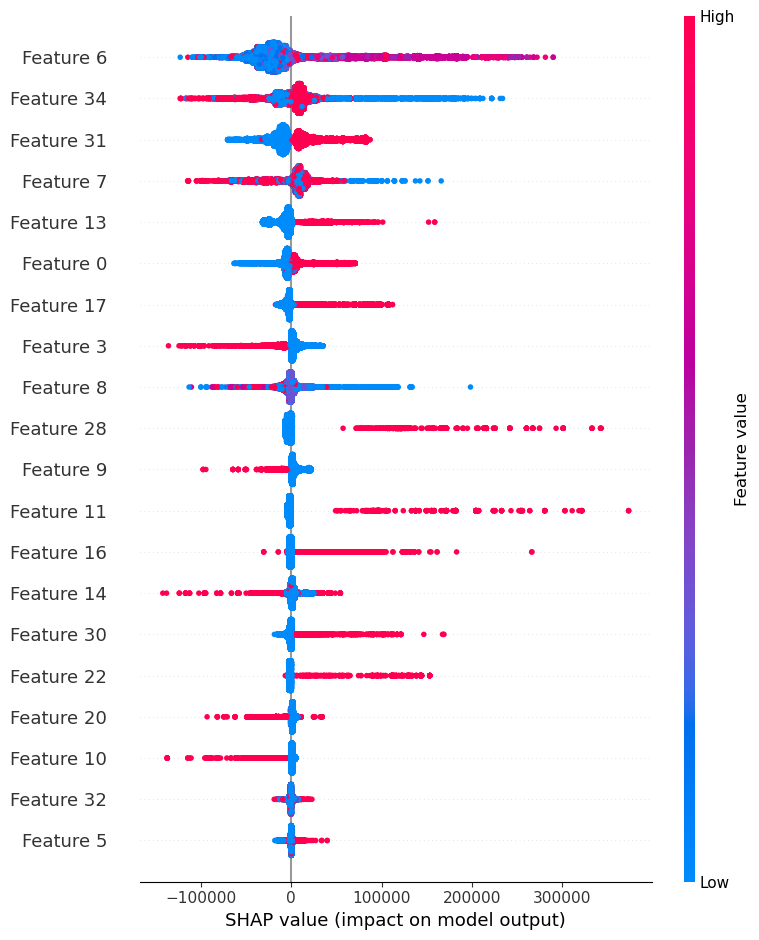

In [40]:
import shap

explainer = shap.Explainer(xgb, X_train_transformed)

# Compute SHAP values for the test set
shap_values = explainer(X_test_transformed)

# Summary plot
shap.summary_plot(shap_values, X_test_transformed)



#### Extracting feature names

In [41]:
# Get feature names
def get_feature_names(column_transformer):
    feature_names = []

    for name, transformer, columns in column_transformer.transformers_:
        if isinstance(transformer, Pipeline):
            current_features = columns
            for step in transformer.steps:
                transformer = step[1]
                if hasattr(transformer, 'get_feature_names_out'):
                    if isinstance(transformer, OneHotEncoder):
                        current_features = transformer.get_feature_names_out(columns)
                    else:
                        current_features = transformer.get_feature_names_out()
            feature_names.extend(current_features)
        else:
            feature_names.extend(columns)
    
    return feature_names

feature_names = get_feature_names(preprocessor)
print(len(feature_names))
print(feature_names)

36
['age_adult(35-60)', 'age_infant(0-2)', 'age_kid(2-12)', 'age_senior(60+)', 'age_teen(12-18)', 'age_young adult(18-35)', 'severity', 'private_attorney', 'marital_status', 'specialty_anesthesiology', 'specialty_cardiology', 'specialty_dermatology', 'specialty_emergency medicine', 'specialty_family practice', 'specialty_general surgery', 'specialty_internal medicine', 'specialty_neurology/neurosurgery', 'specialty_obgyn', 'specialty_occupational medicine', 'specialty_ophthamology', 'specialty_orthopedic surgery', 'specialty_pathology', 'specialty_pediatrics', 'specialty_physical medicine', 'specialty_plastic surgeon', 'specialty_radiology', 'specialty_resident', 'specialty_thoracic surgery', 'specialty_urological surgery', 'insurance_medicare/medicaid', 'insurance_no insurance', 'insurance_private', 'insurance_unknown', 'insurance_workers compensation', 'gender_female', 'gender_male']


### Residual Plot

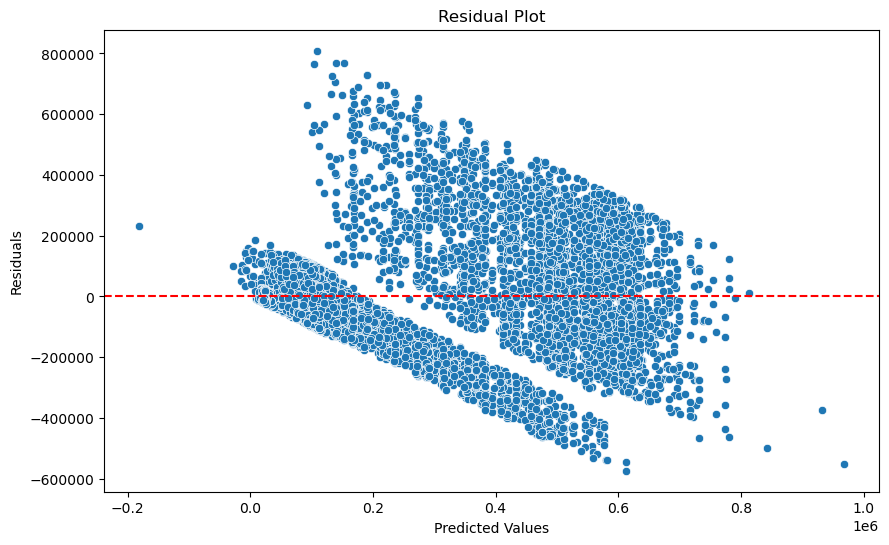

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

The points are scattered around 0, We can say that, the model captures the details and the model is probably a good fit

### Predicted vs Actual Plot

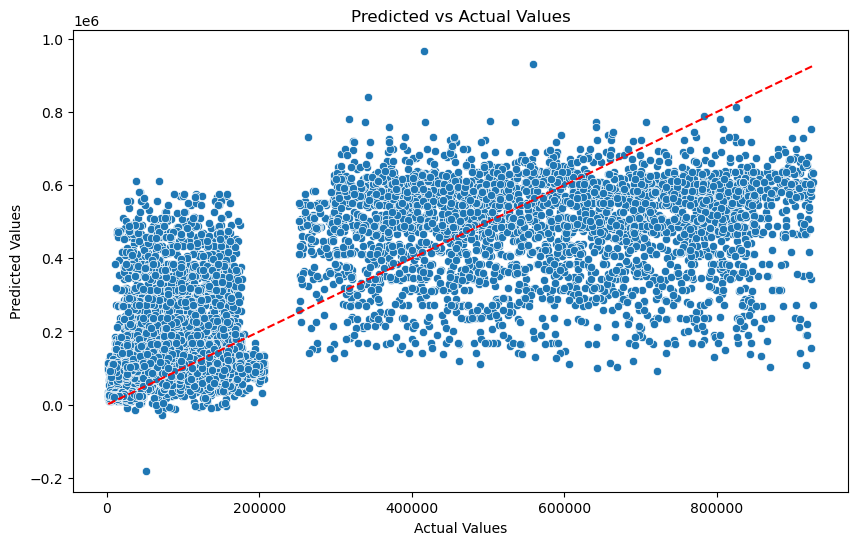

In [44]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.show()

### Histogram of Residuals

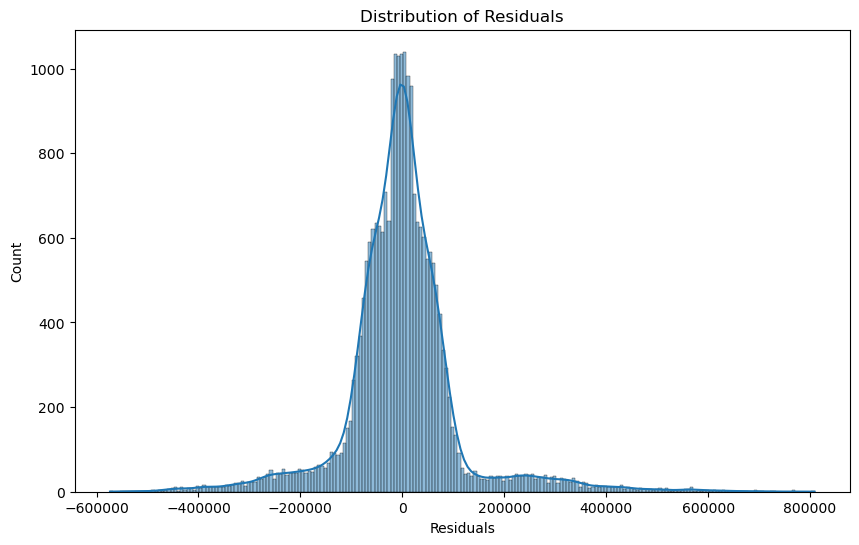

In [45]:
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()

The distribution of the residuals is normal

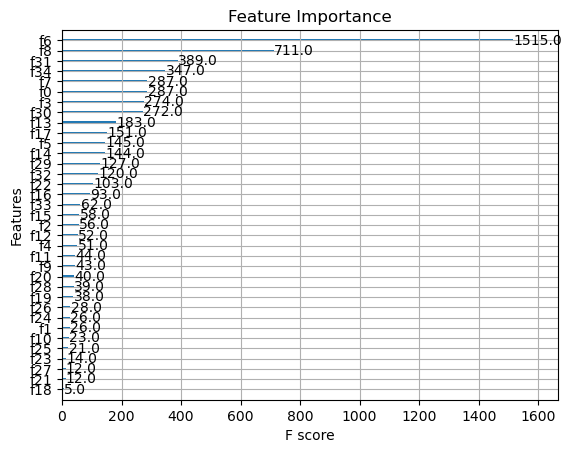

In [46]:
# For XGBoost
from xgboost import plot_importance

plot_importance(xgb)
plt.title('Feature Importance')
plt.show()